#### Key Insights From EDA

1. Number of transactions follow patterns that are seasonal in nature. Consequently, the predictions for the same customer could differ based on the window being considered.
2. Repeat customer rate is high and previous preferences of the customer would be crucial in recommending articles.
3. Top selling items across age-groups vary widely.

In [3]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
# Let's convert back to parquet and load it in parquet format
transactions.to_parquet('transactions.parquet')
transactions_parquet = pd.read_parquet('./transactions.parquet')
del transactions # to save space

articles = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv')

#### Memory Optimization

Convert the columns customer_id and article_id from string to integers to save space. 
1. customer_id is stored as a 64 byte string; converting it to int64 (8 bytes) ==> saves 8x space.
2. article_id is stored as a 10 byte string. Remove the leading 0 and convert it to int32 (4 Bytes) ==> saves 2.5x space

In [6]:
transactions_parquet['customer_id2'] =\
    transactions_parquet['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

customers['customer_id'] = customers['customer_id'].apply(lambda x: int(x[-16:], 16) ).astype('int64')

print(transactions_parquet['customer_id2'].nunique())
print(transactions_parquet['customer_id'].nunique())

transactions_parquet.drop(['customer_id'], axis=1, inplace=True)
transactions_parquet.rename(columns={'customer_id2': 'customer_id'}, inplace=True)
transactions_parquet.head(3)

1362281
1362281


,t_dat,article_id,price,sales_channel_id,customer_id
0,2018-09-20,663713001,0.050831,2,-6846340800584936
1,2018-09-20,541518023,0.030492,2,-6846340800584936
2,2018-09-20,505221004,0.015237,2,-8334631767138808638


Quick check to ensure 1-1 mapping after converting to int32

In [7]:
transactions_parquet['article_id2'] = transactions_parquet['article_id'].astype('int32')
# Quick check to ensure 1-1 mapping after converting to int32
print(transactions_parquet['article_id2'].nunique())
print(transactions_parquet['article_id'].nunique())

transactions_parquet.rename({'article_id2':'article_id'}, inplace=True)
articles['article_id'] = articles['article_id'].astype('int32')

104547
104547


# EDA

In [8]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
display_html(articles.head(3))
print("\n", clr.S+"CUSTOMERS:"+clr.E, customers.shape)
display_html(customers.head(3))
print("\n", clr.S+"TRANSACTIONS:"+clr.E, transactions_parquet.shape)
display_html(transactions_parquet.head(3))

print("\n", clr.S + "Number of unique customers =" + clr.E, transactions_parquet['customer_id'].nunique())
print("\n", clr.S + "Number of unique articles purchased = " + clr.E, transactions_parquet['article_id'].nunique())
print("\n", clr.S + "Number of transactions = " + clr.E, transactions_parquet.shape[0])


a = transactions_parquet['sales_channel_id'].value_counts()
print("\n", clr.S + "Pct of Channel 1 purchases = " + clr.E, round((a[1]*100/(a[1]+a[2])), 3), "%")
print("\n", clr.S + "Pct of Channel 2 purchases = " + clr.E, round((a[2]*100.0/(a[1]+a[2])), 3), "%")

print("\n", clr.S + "Start Date:" + clr.E, transactions_parquet['t_dat'].min())
print("\n", clr.S + "End Date:" + clr.E, transactions_parquet['t_dat'].max())

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.



 CUSTOMERS: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...



 TRANSACTIONS: (31788324, 6)


,t_dat,article_id,price,sales_channel_id,customer_id,article_id2
0,2018-09-20,663713001,0.050831,2,-6846340800584936,663713001
1,2018-09-20,541518023,0.030492,2,-6846340800584936,541518023
2,2018-09-20,505221004,0.015237,2,-8334631767138808638,505221004



 Number of unique customers = 1362281

 Number of unique articles purchased =  104547

 Number of transactions =  31788324

 Pct of Channel 1 purchases =  29.597 %

 Pct of Channel 2 purchases =  70.403 %

 Start Date: 2018-09-20

 End Date: 2020-09-22


# Articles - EDA

##### Helper Functions 

In [9]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x

def insert_image(path, zoom, xybox, ax):
    '''Insert an image within matplotlib'''
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)

def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: whether or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def convert_to_date(s):
    """
    Memoization technique - very fast conversion to pure python dates
    """
    dates = {date:datetime.datetime.strptime(date,'%Y-%m') for date in s.unique()}
    return s.map(dates)


def plot_values( df, col):

    print(clr.S+ f"Total Number of unique {col} values:"+clr.E, df[col].nunique())

    # Data
    val_cnt = df[col].value_counts().reset_index().head(15)
    clrs = ['#954E93' for x in val_cnt[col]]
    # clrs = ["#CB2170" if x==max(val_cnt[col]) else '#954E93' for x in val_cnt[col]]
    
    
    # Plot
    fig, ax = plt.subplots(figsize=(25, 13))
    plt.title(f'- Most Frequent {col} values -', size=22, weight="bold")
    
    sns.barplot(data=val_cnt, x="count", y=col, ax=ax,
                palette=clrs)

    show_values_on_bars(ax, h_v="h")
    
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.show()

#### Missing Value Check

In [10]:
articles.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [11]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
      articles.isna().sum()[-1], "total missing values")
# Replace missing values
articles.fillna(value="No Description", inplace=True)

There are no missing values in any columns but 'Detail Description': 416 total missing values


Total Number of unique prod_name values: 45875


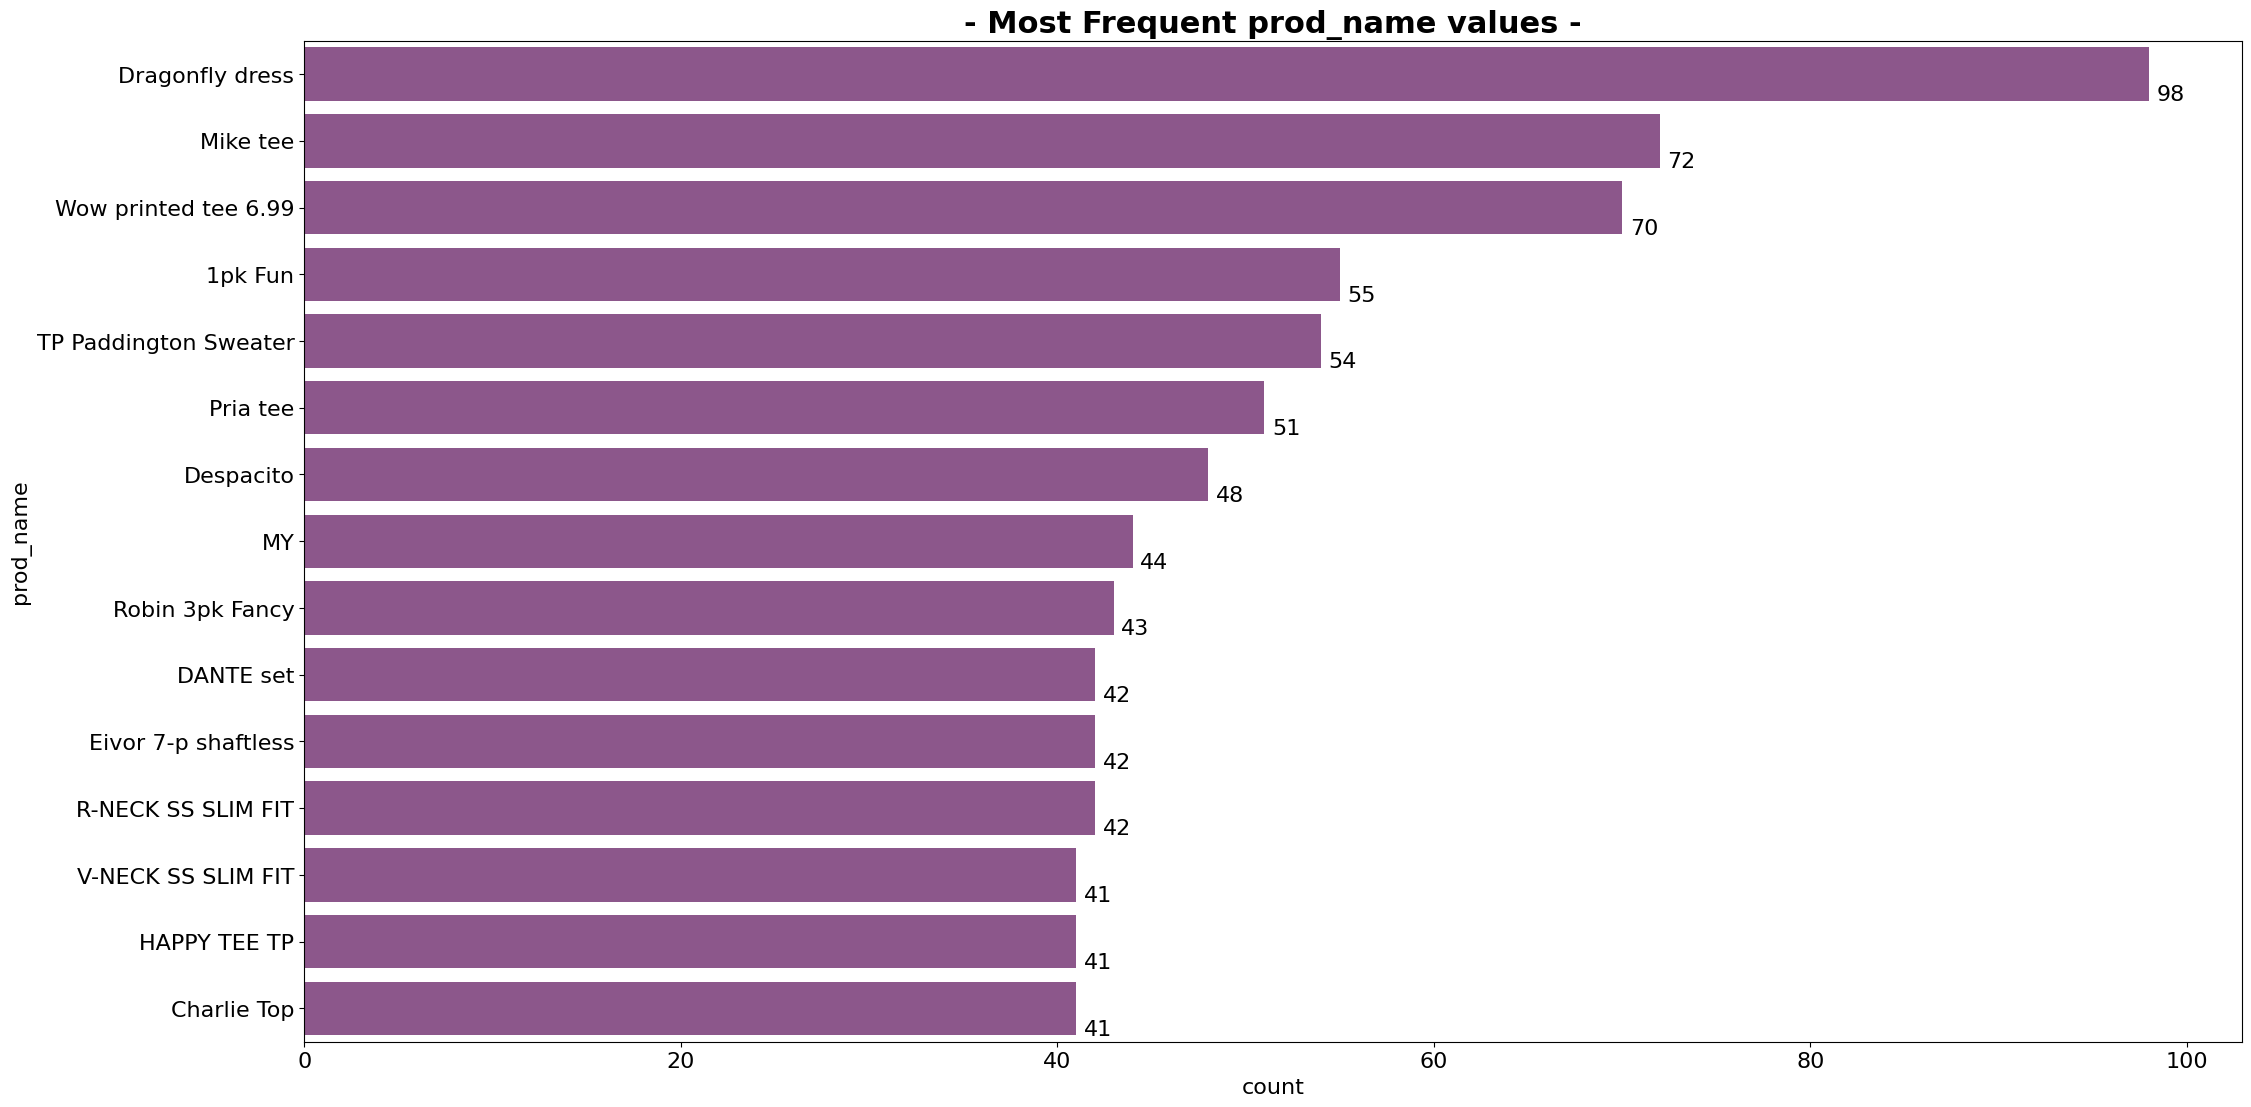

Total Number of unique product_type_name values: 131


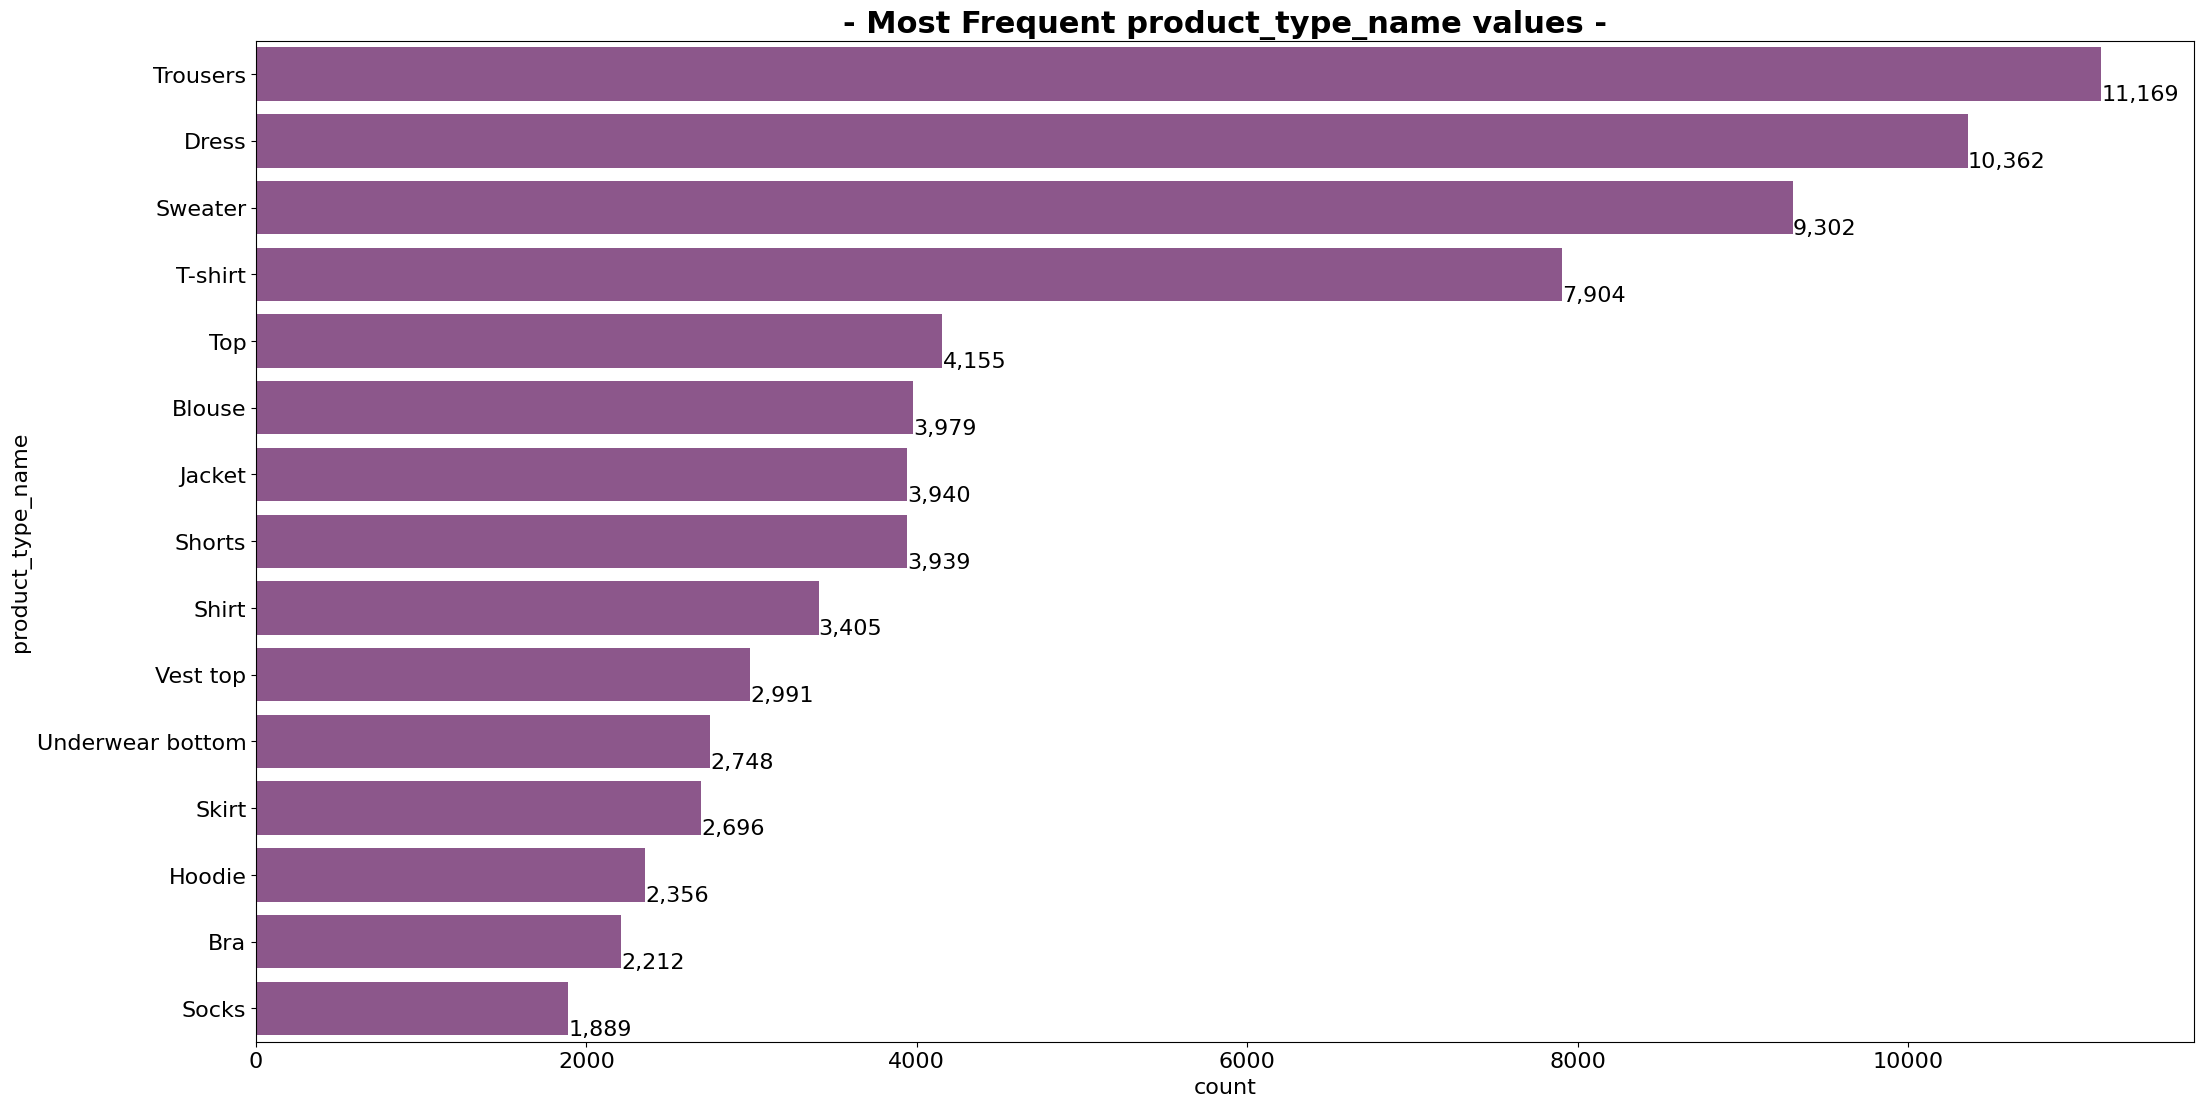

Total Number of unique graphical_appearance_name values: 30


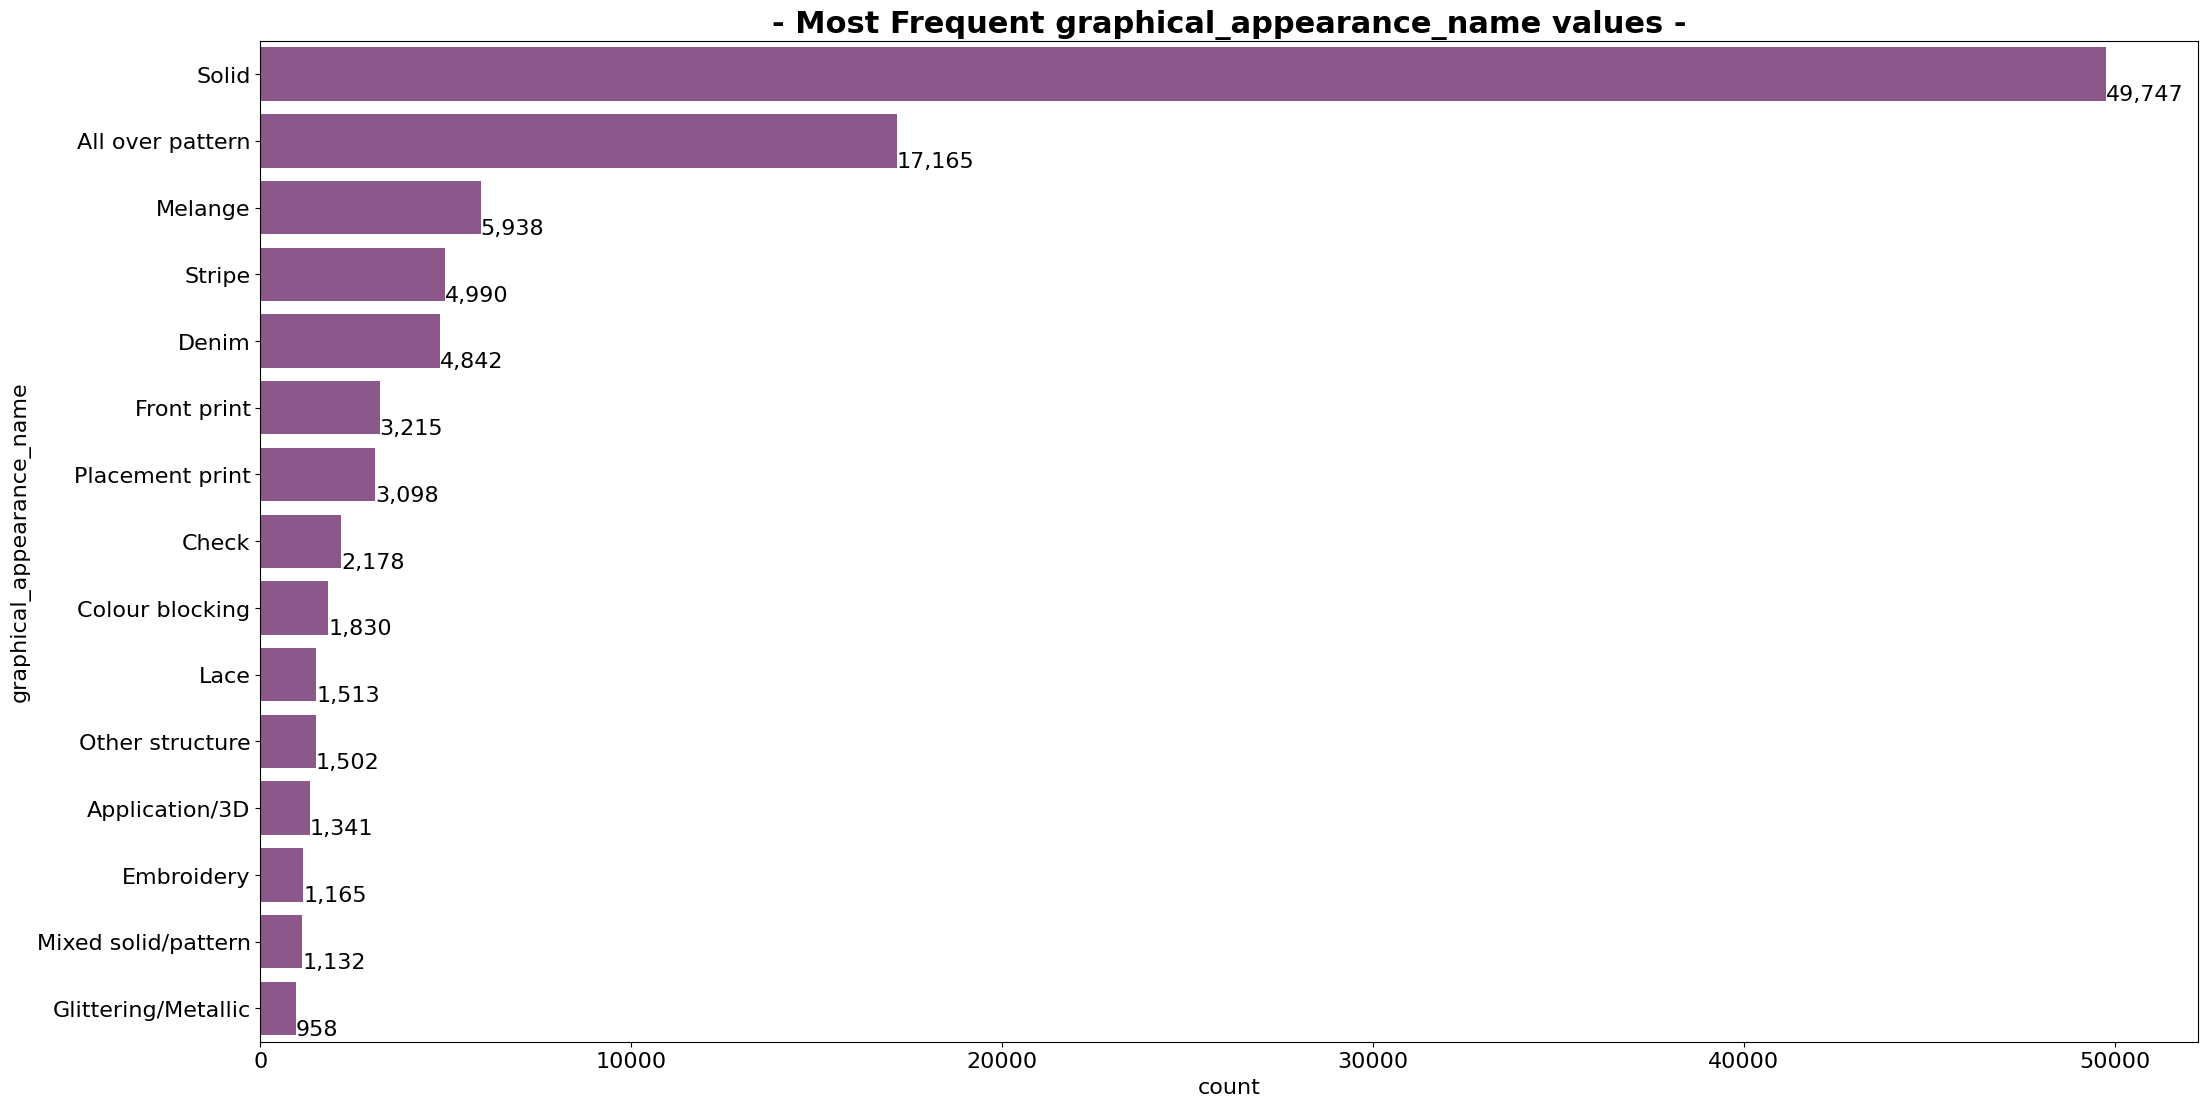

Total Number of unique colour_group_name values: 50


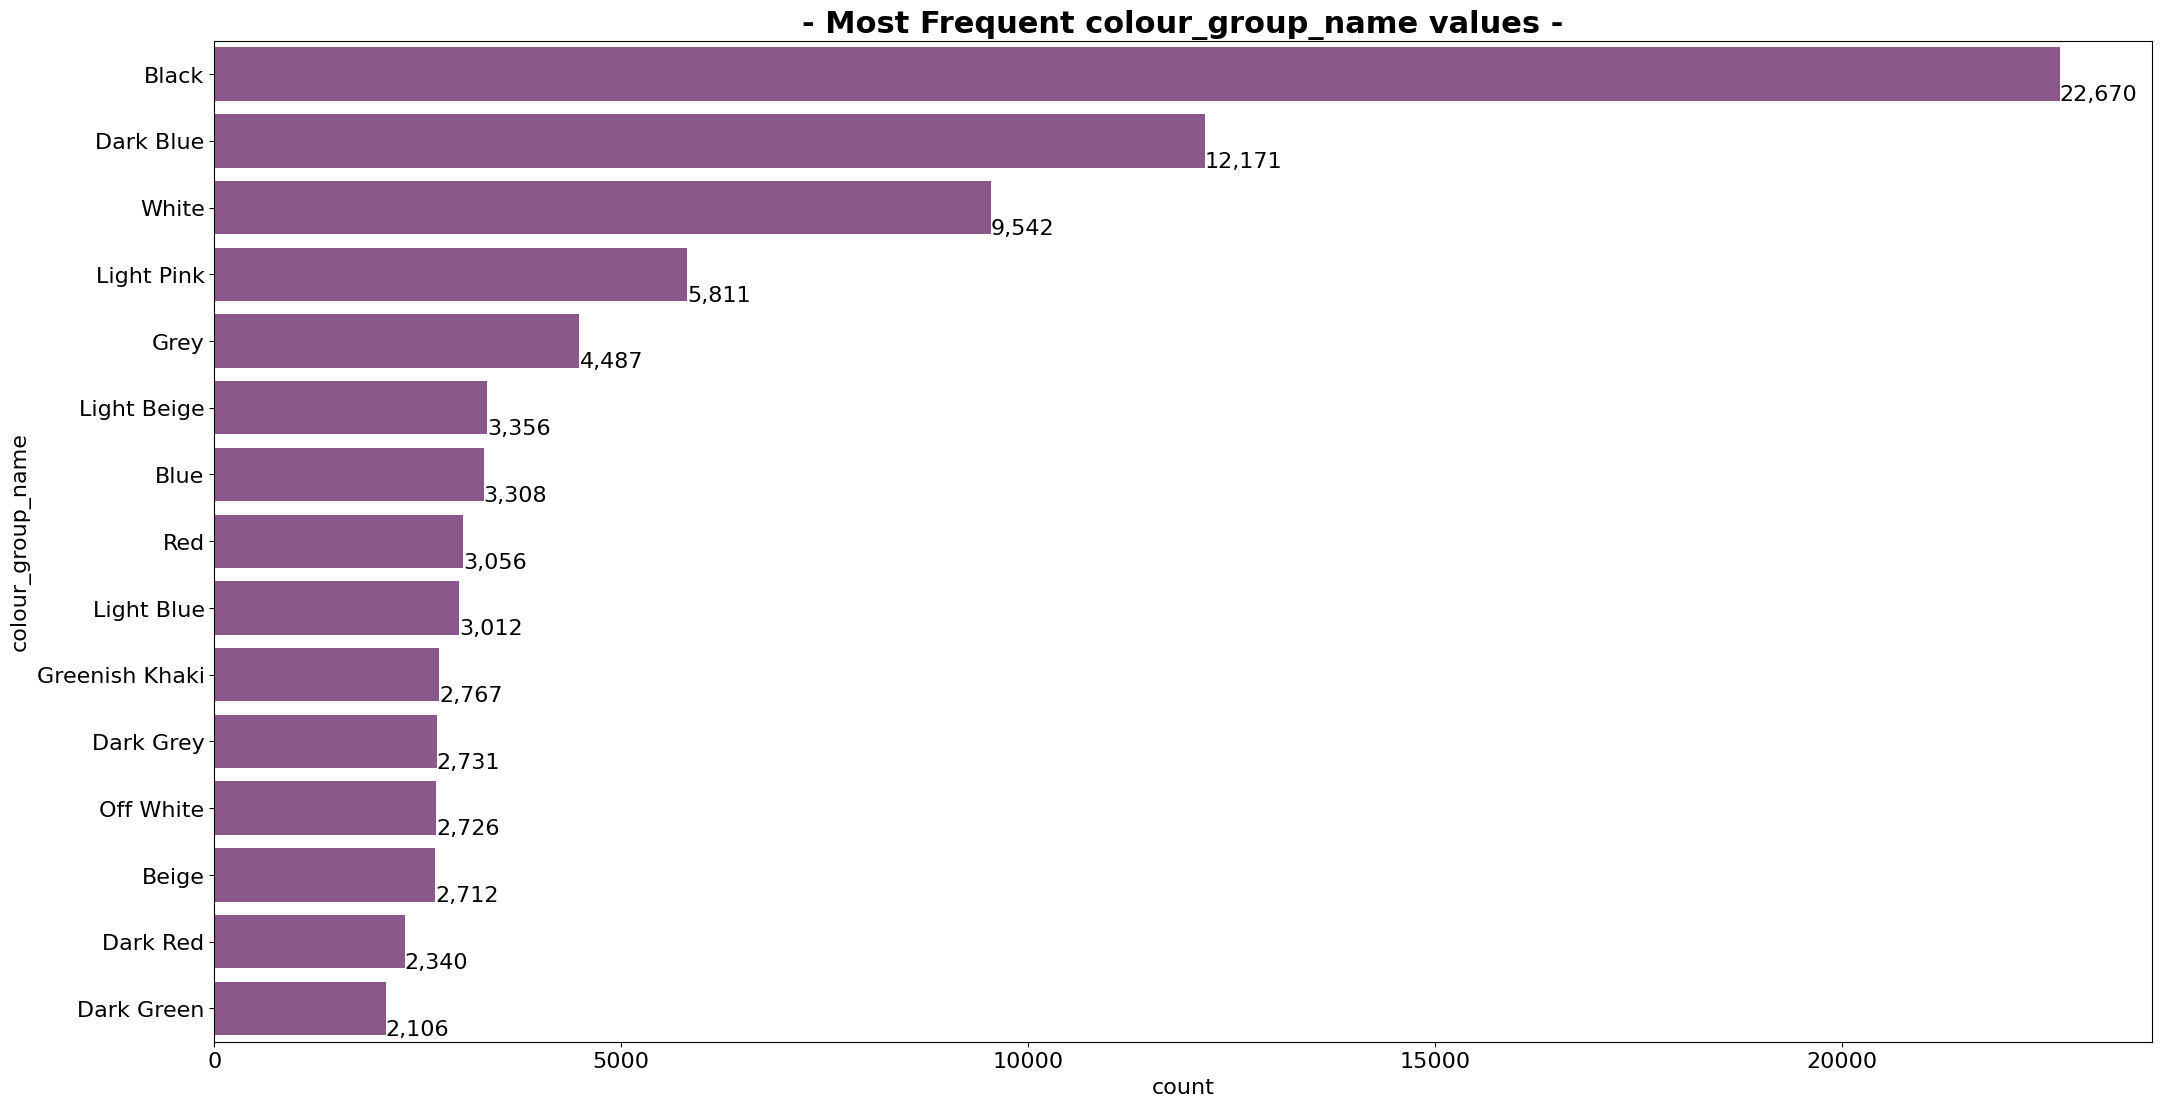

Total Number of unique perceived_colour_value_name values: 8


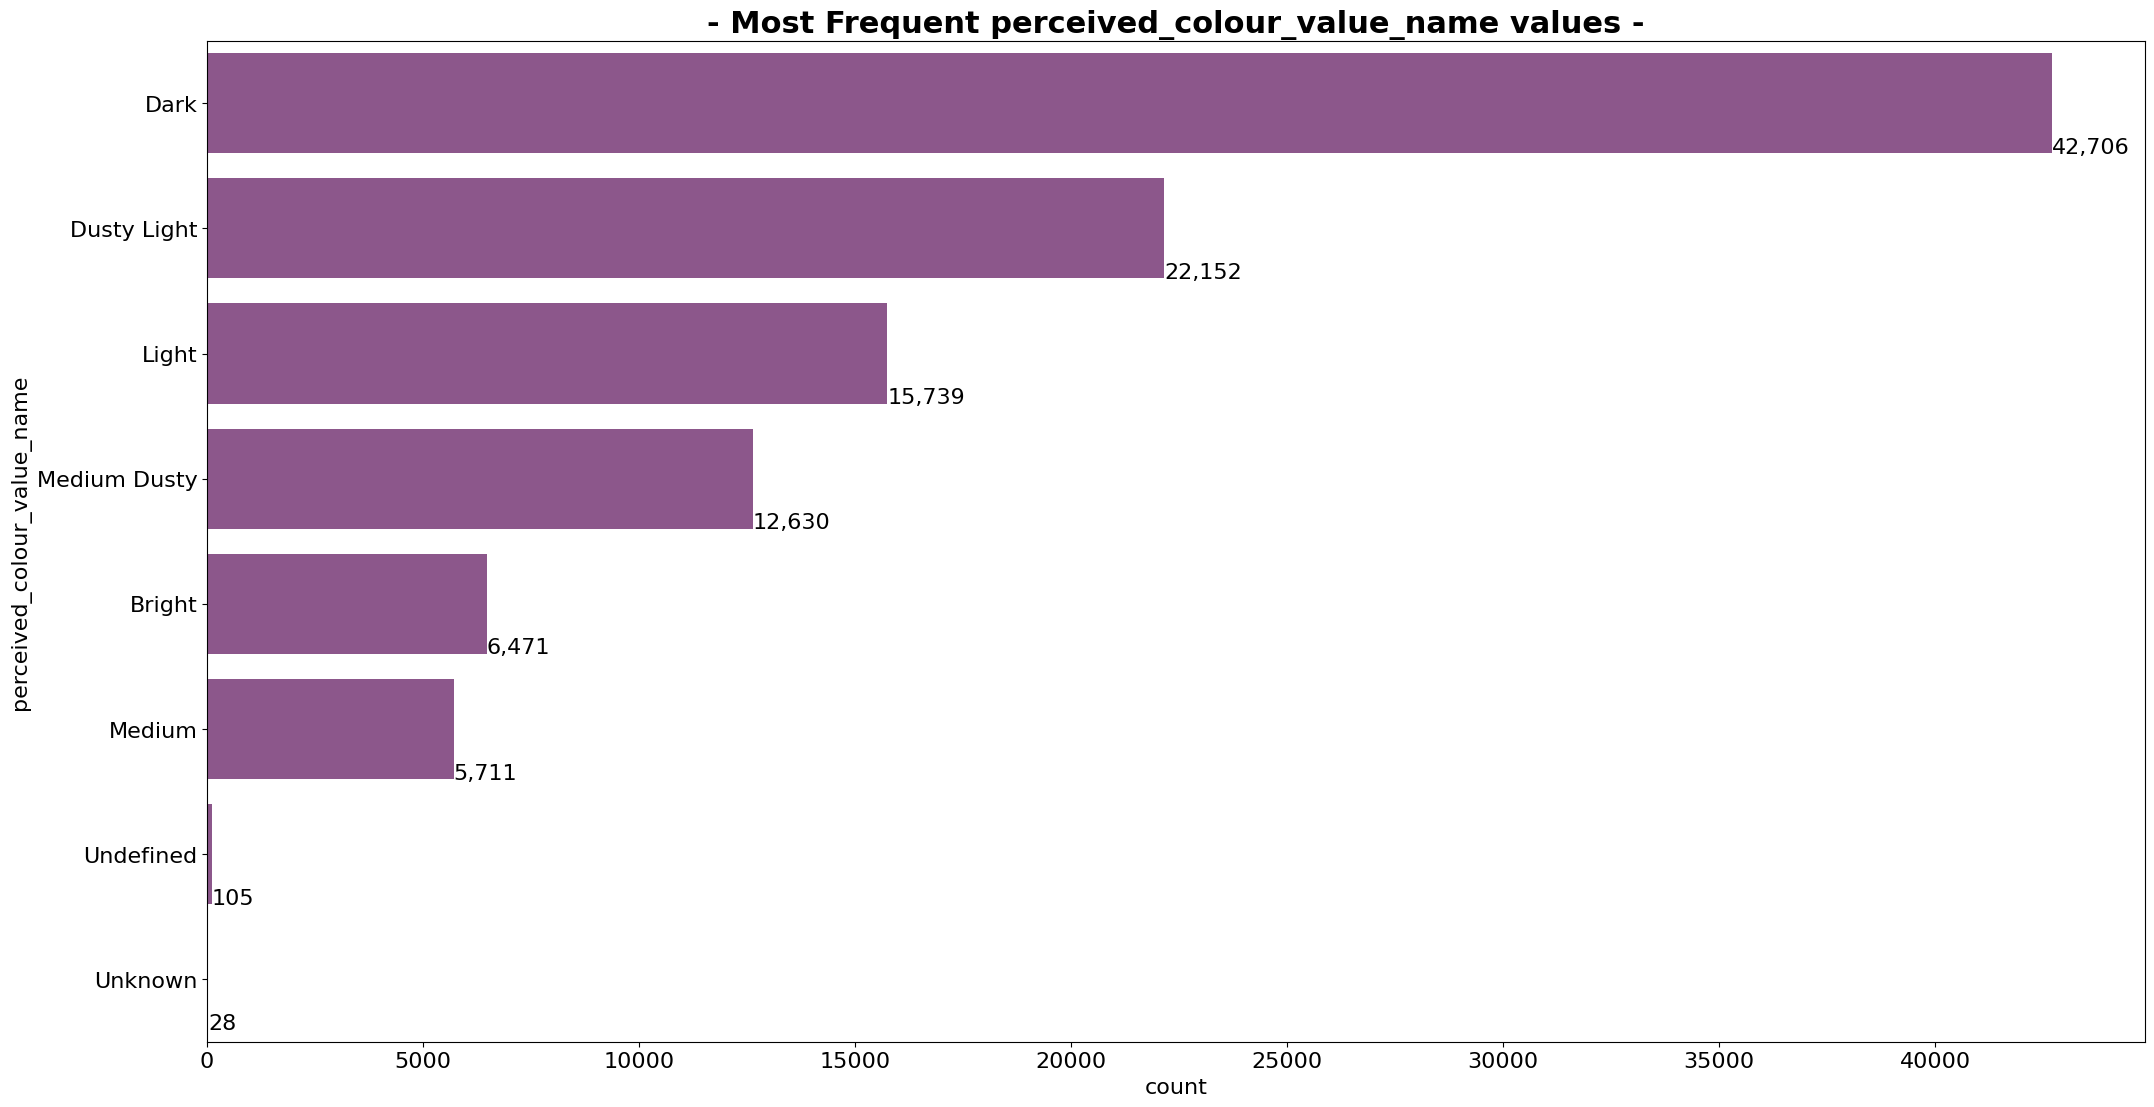

Total Number of unique department_name values: 250


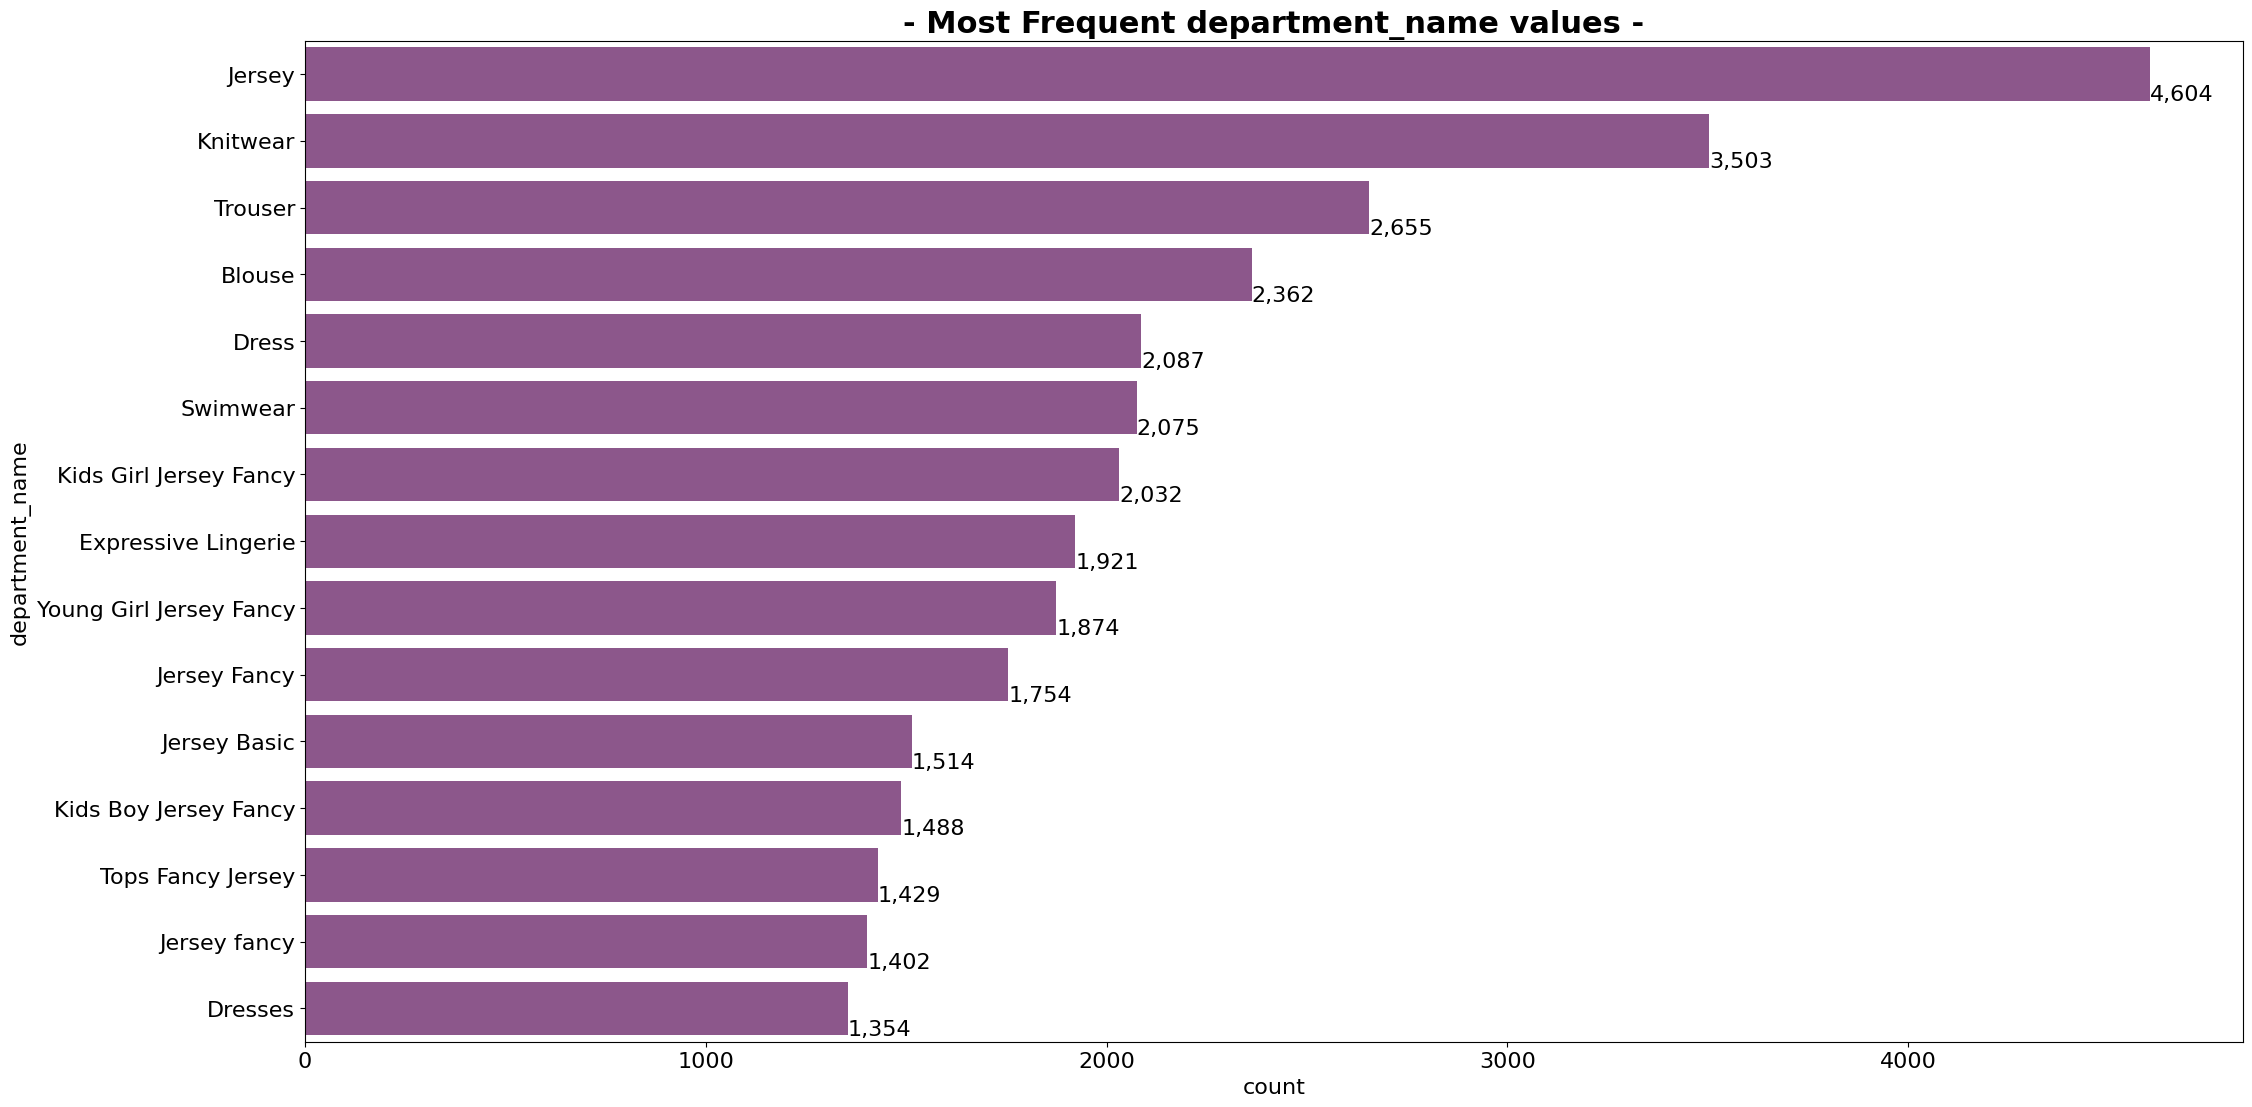

Total Number of unique index_name values: 10


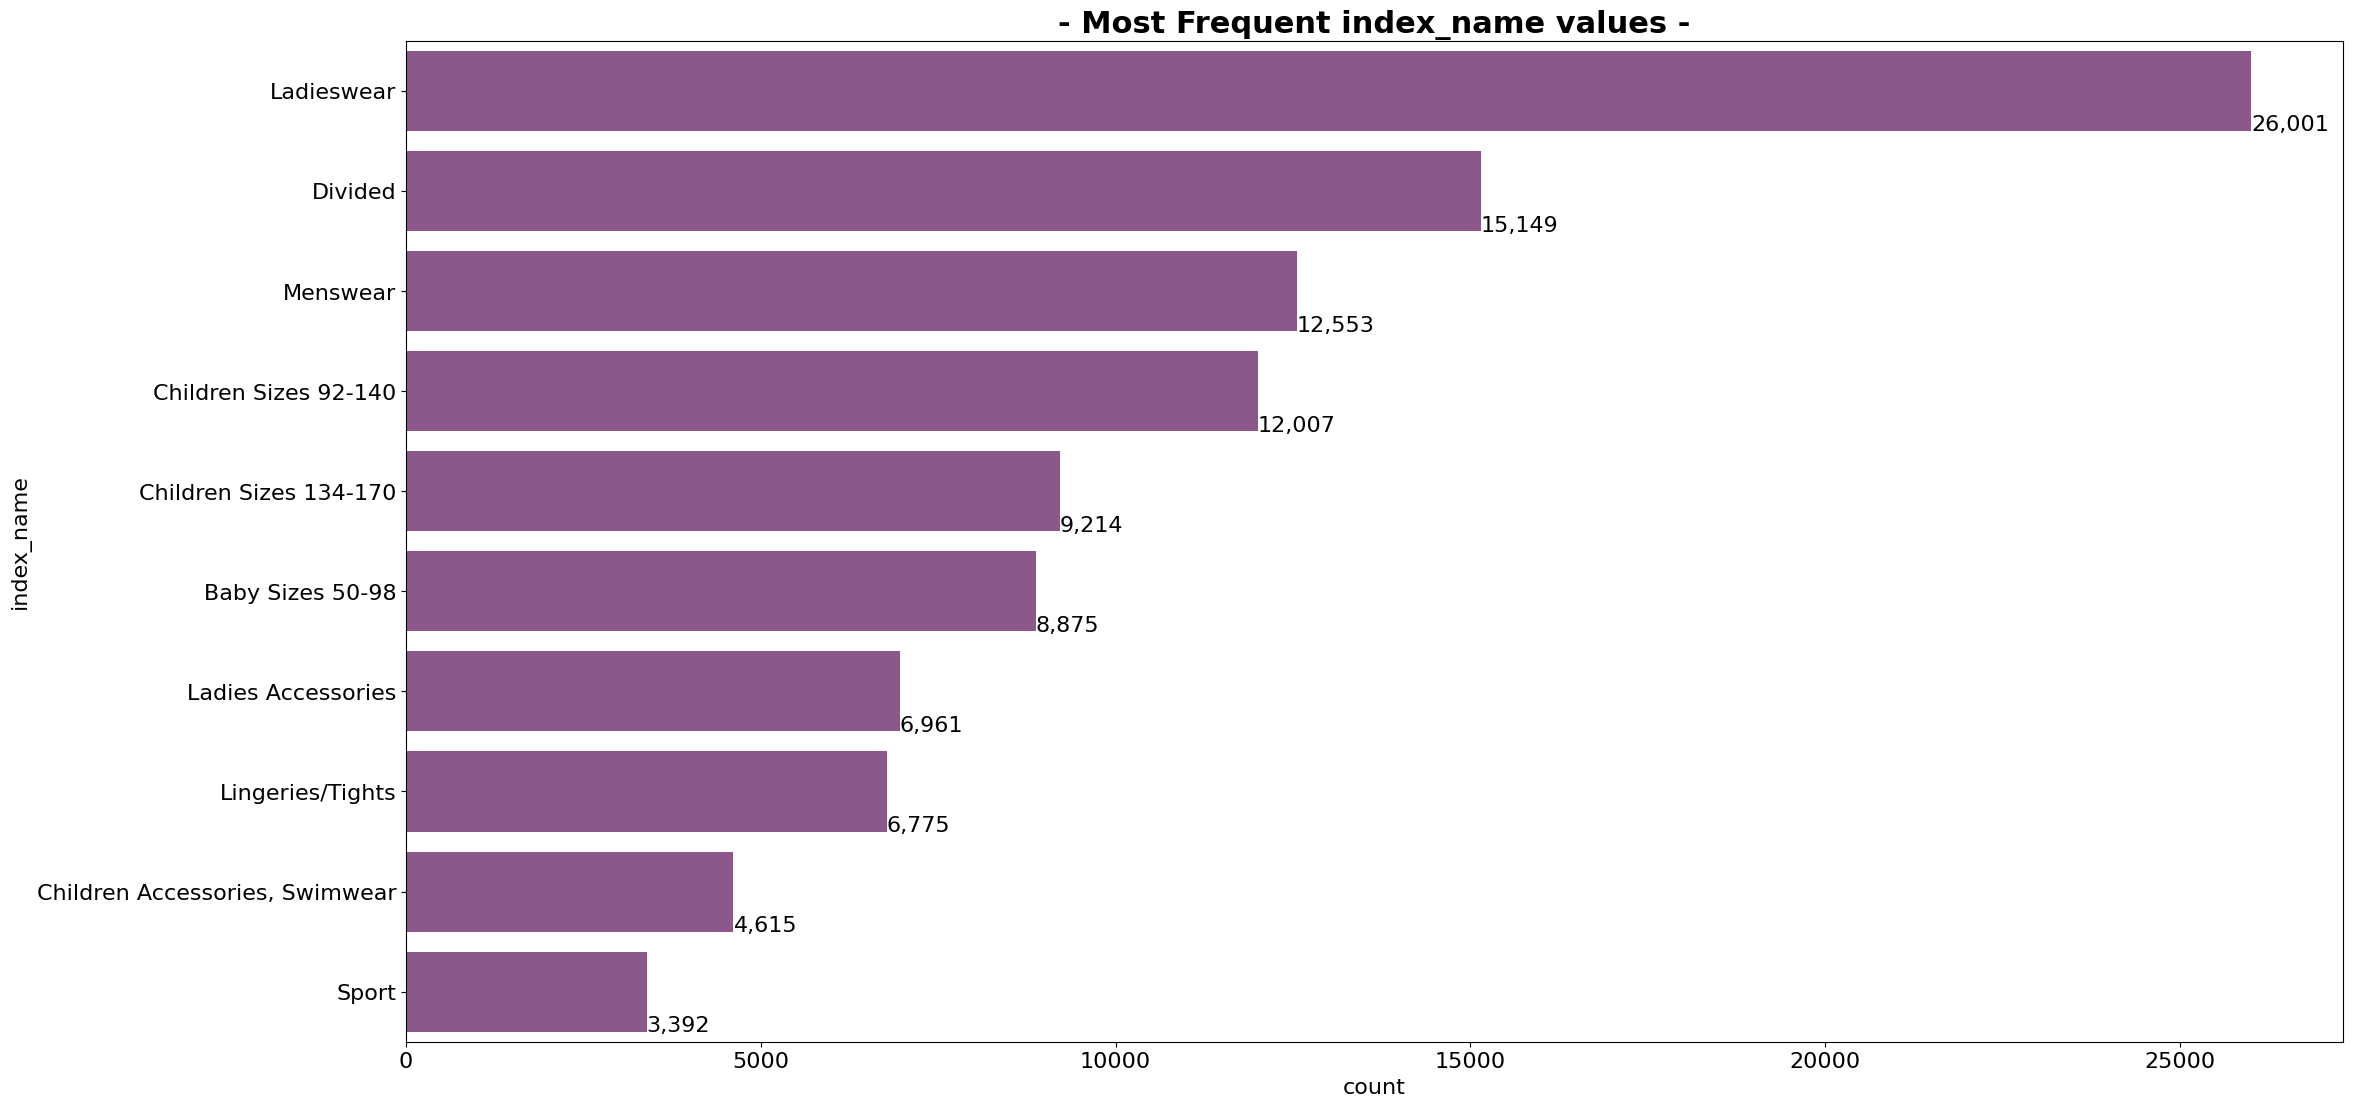

Total Number of unique index_group_name values: 5


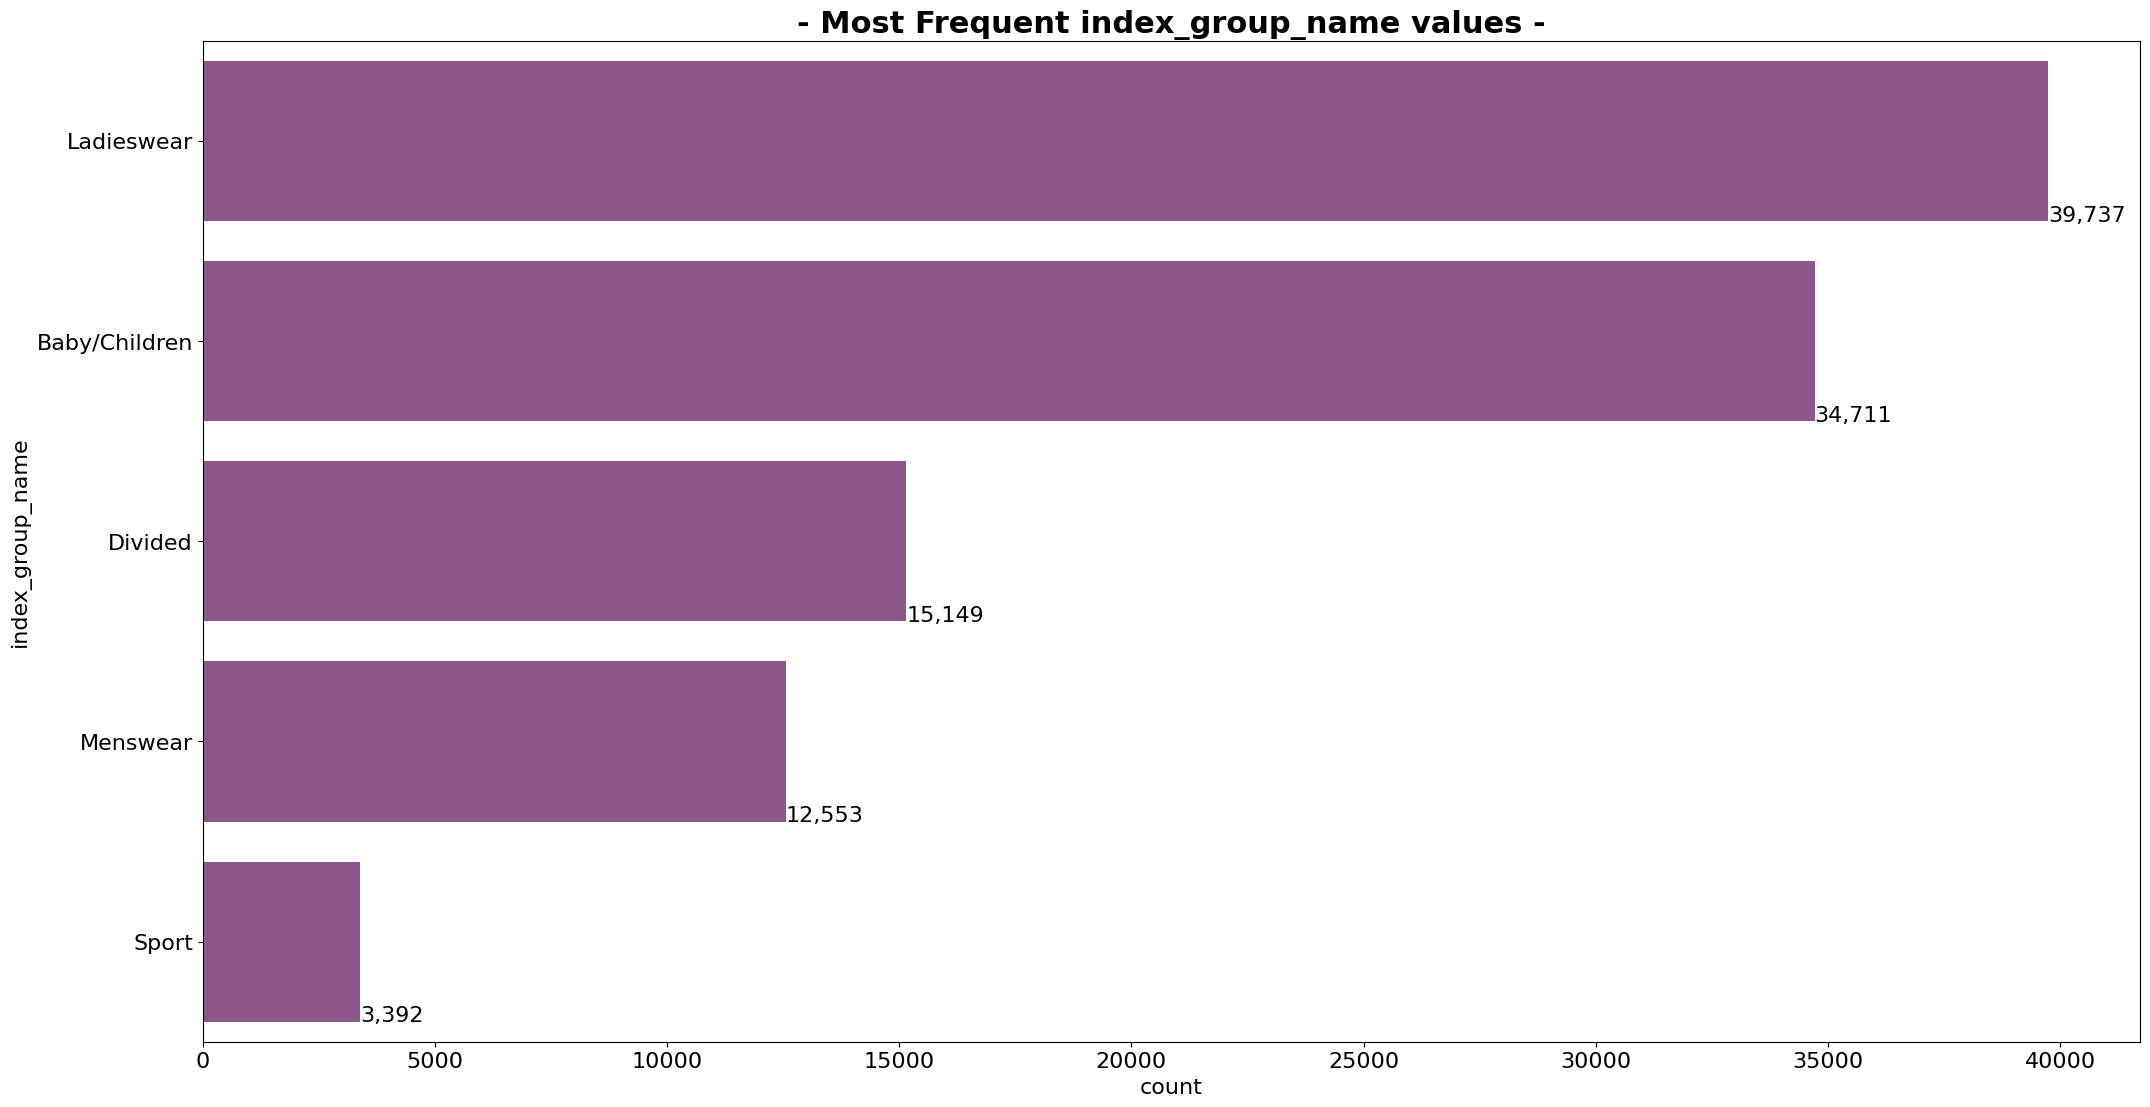

Total Number of unique section_name values: 56


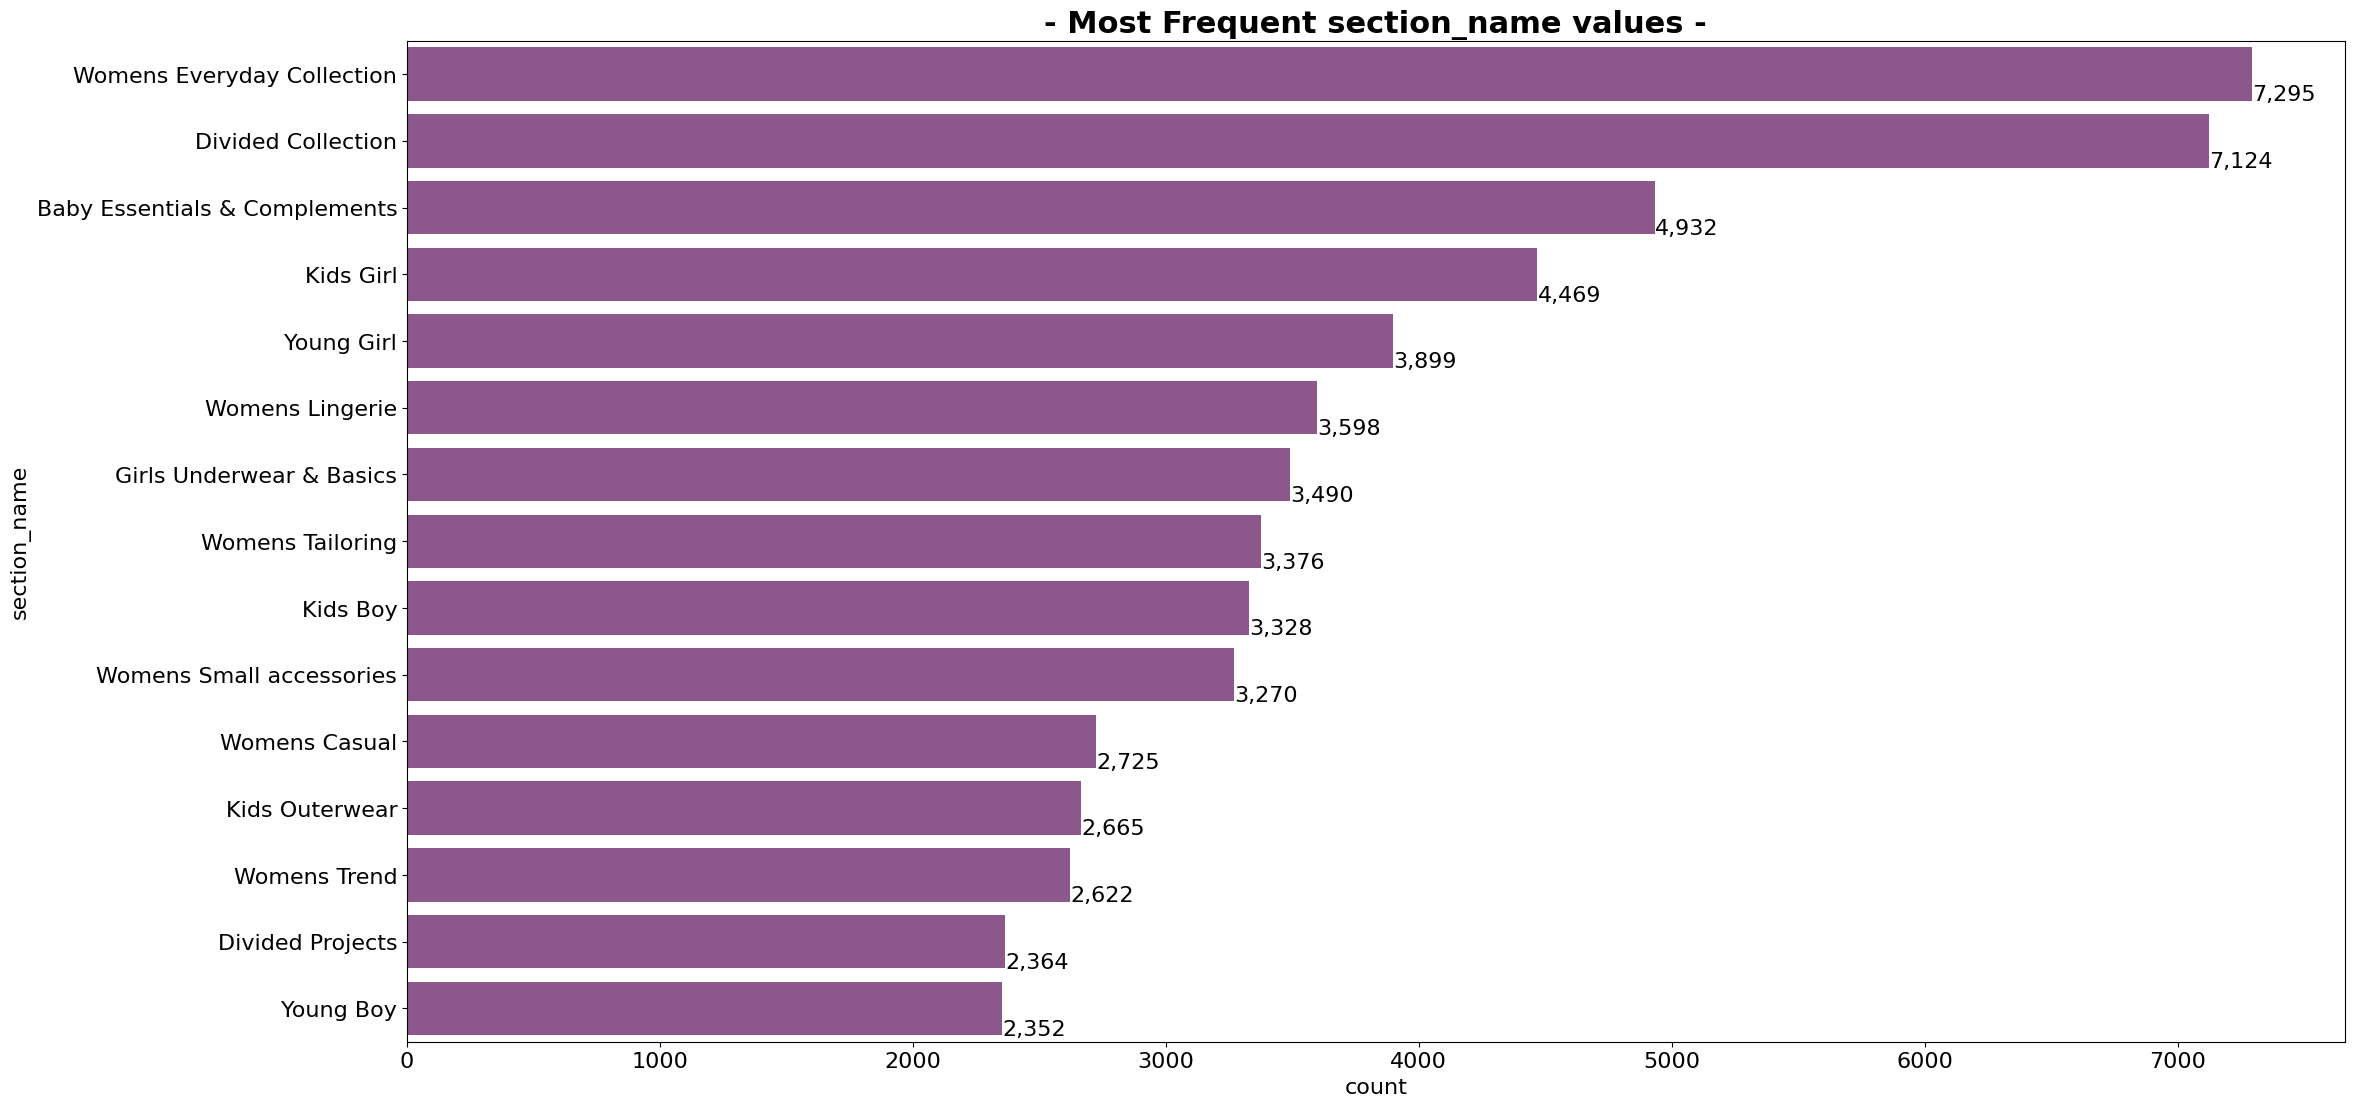

Total Number of unique garment_group_name values: 21


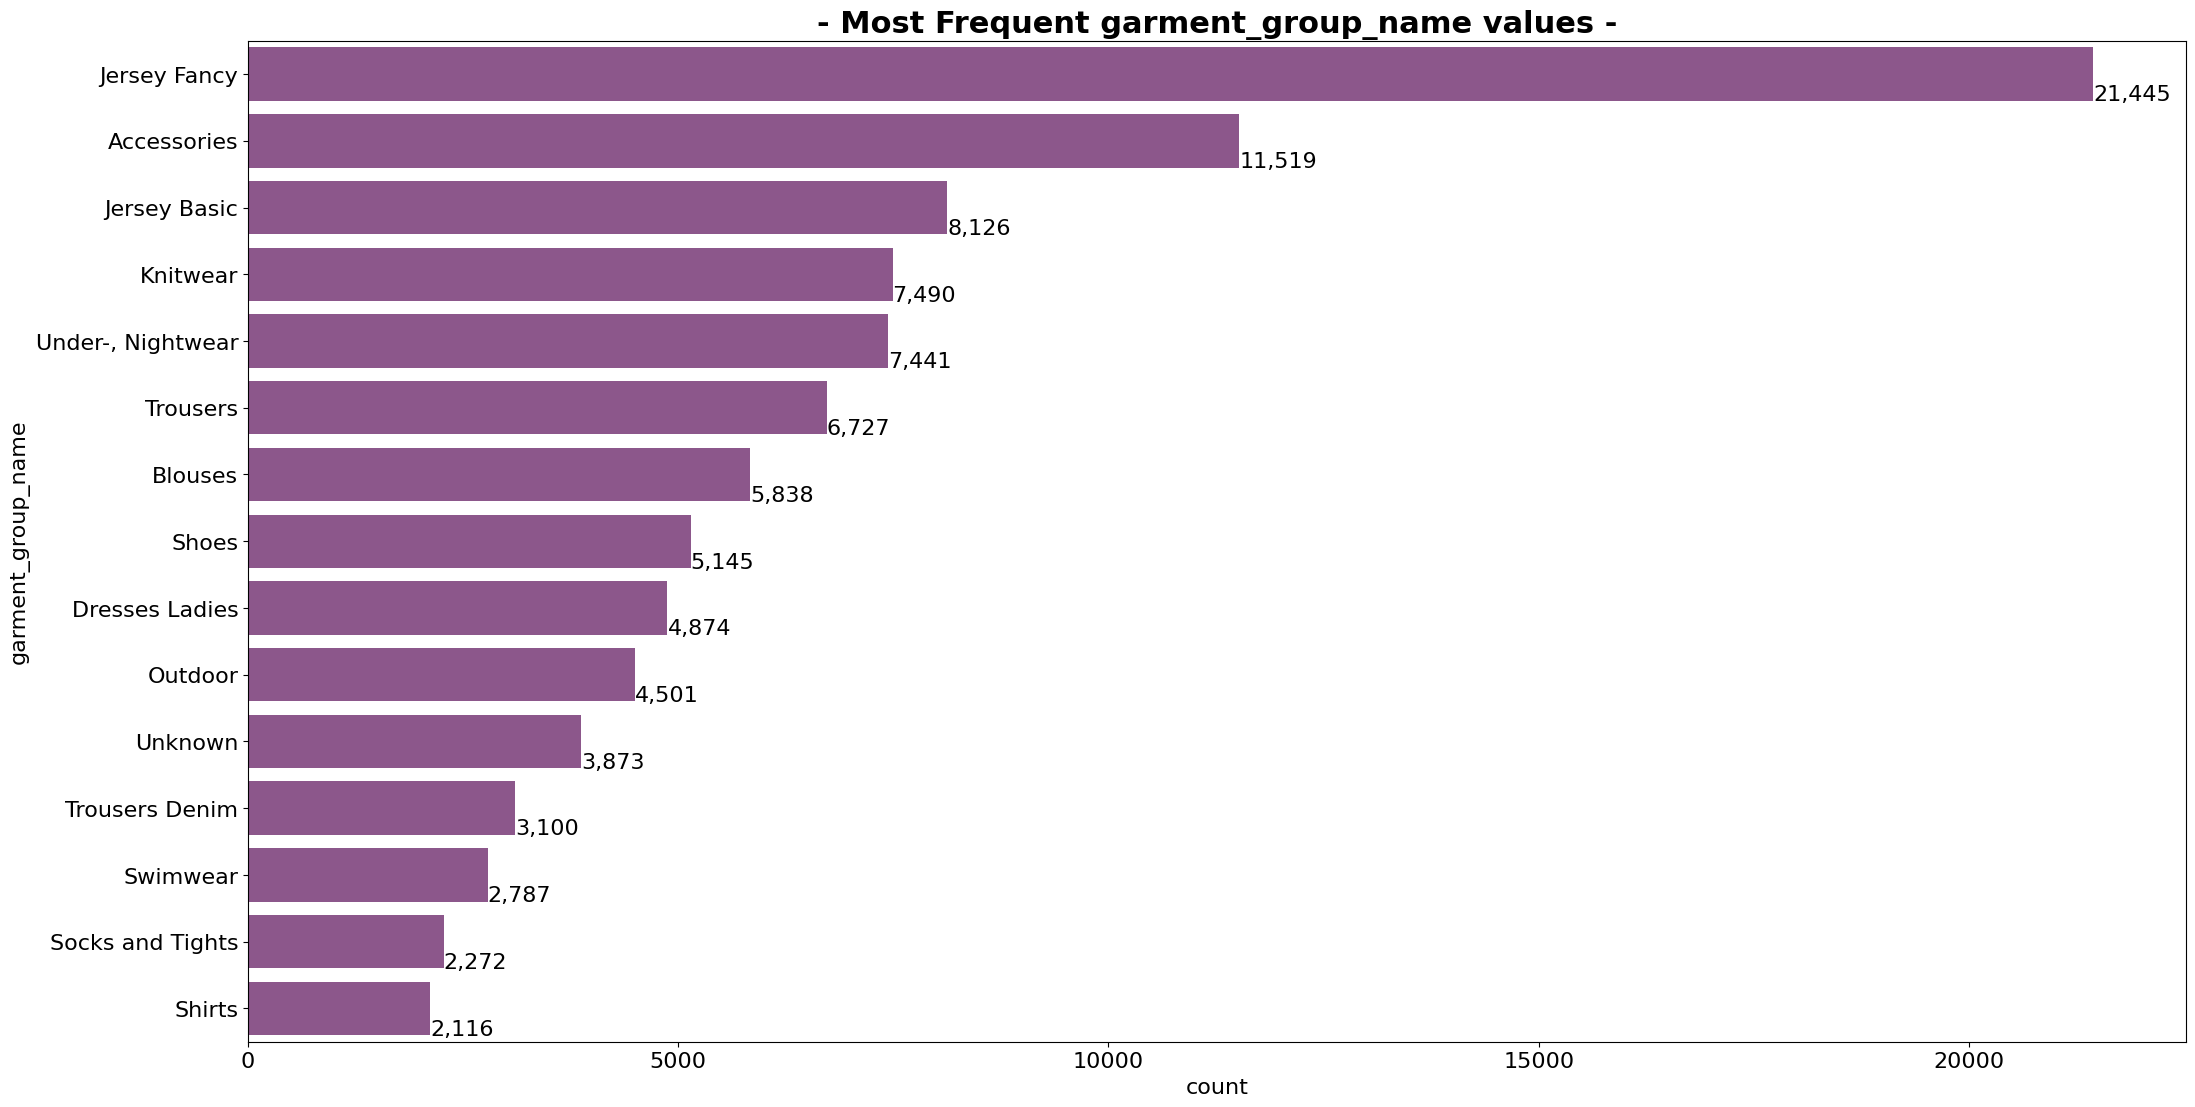

In [12]:
analyse_cols = ['prod_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name',
                    'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']

for col in analyse_cols:
    plot_values( articles, col)

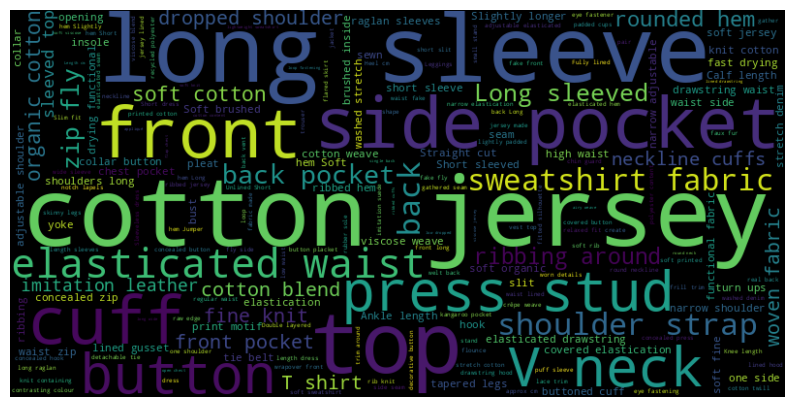

In [13]:
text = ' '.join(articles['detail_desc'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Transactions - EDA

1. Transaction volumes fell in the first half of 2020 (Covid) and picked up in the second half.
2. Every month has at least a million transactions. The month of June is the busiest.
4. Number of daily transactions fluctuates between 25,000 and 50,000.
5. Spikes in daily transaction volumes could be due to festivals and sales.
6. Sales 1 - sales 2 split is 30-70.
7. Distribution of transaction amounts is skewed towards lower values --> Lower valued products sell more.
8. Repeat customer rate is high - 130K customers have made only one purchase, 40K customers with 10 purchases and 20K.

In [14]:
transactions_parquet.head()

,t_dat,article_id,price,sales_channel_id,customer_id,article_id2
0,2018-09-20,663713001,0.050831,2,-6846340800584936,663713001
1,2018-09-20,541518023,0.030492,2,-6846340800584936,541518023
2,2018-09-20,505221004,0.015237,2,-8334631767138808638,505221004
3,2018-09-20,685687003,0.016932,2,-8334631767138808638,685687003
4,2018-09-20,685687004,0.016932,2,-8334631767138808638,685687004


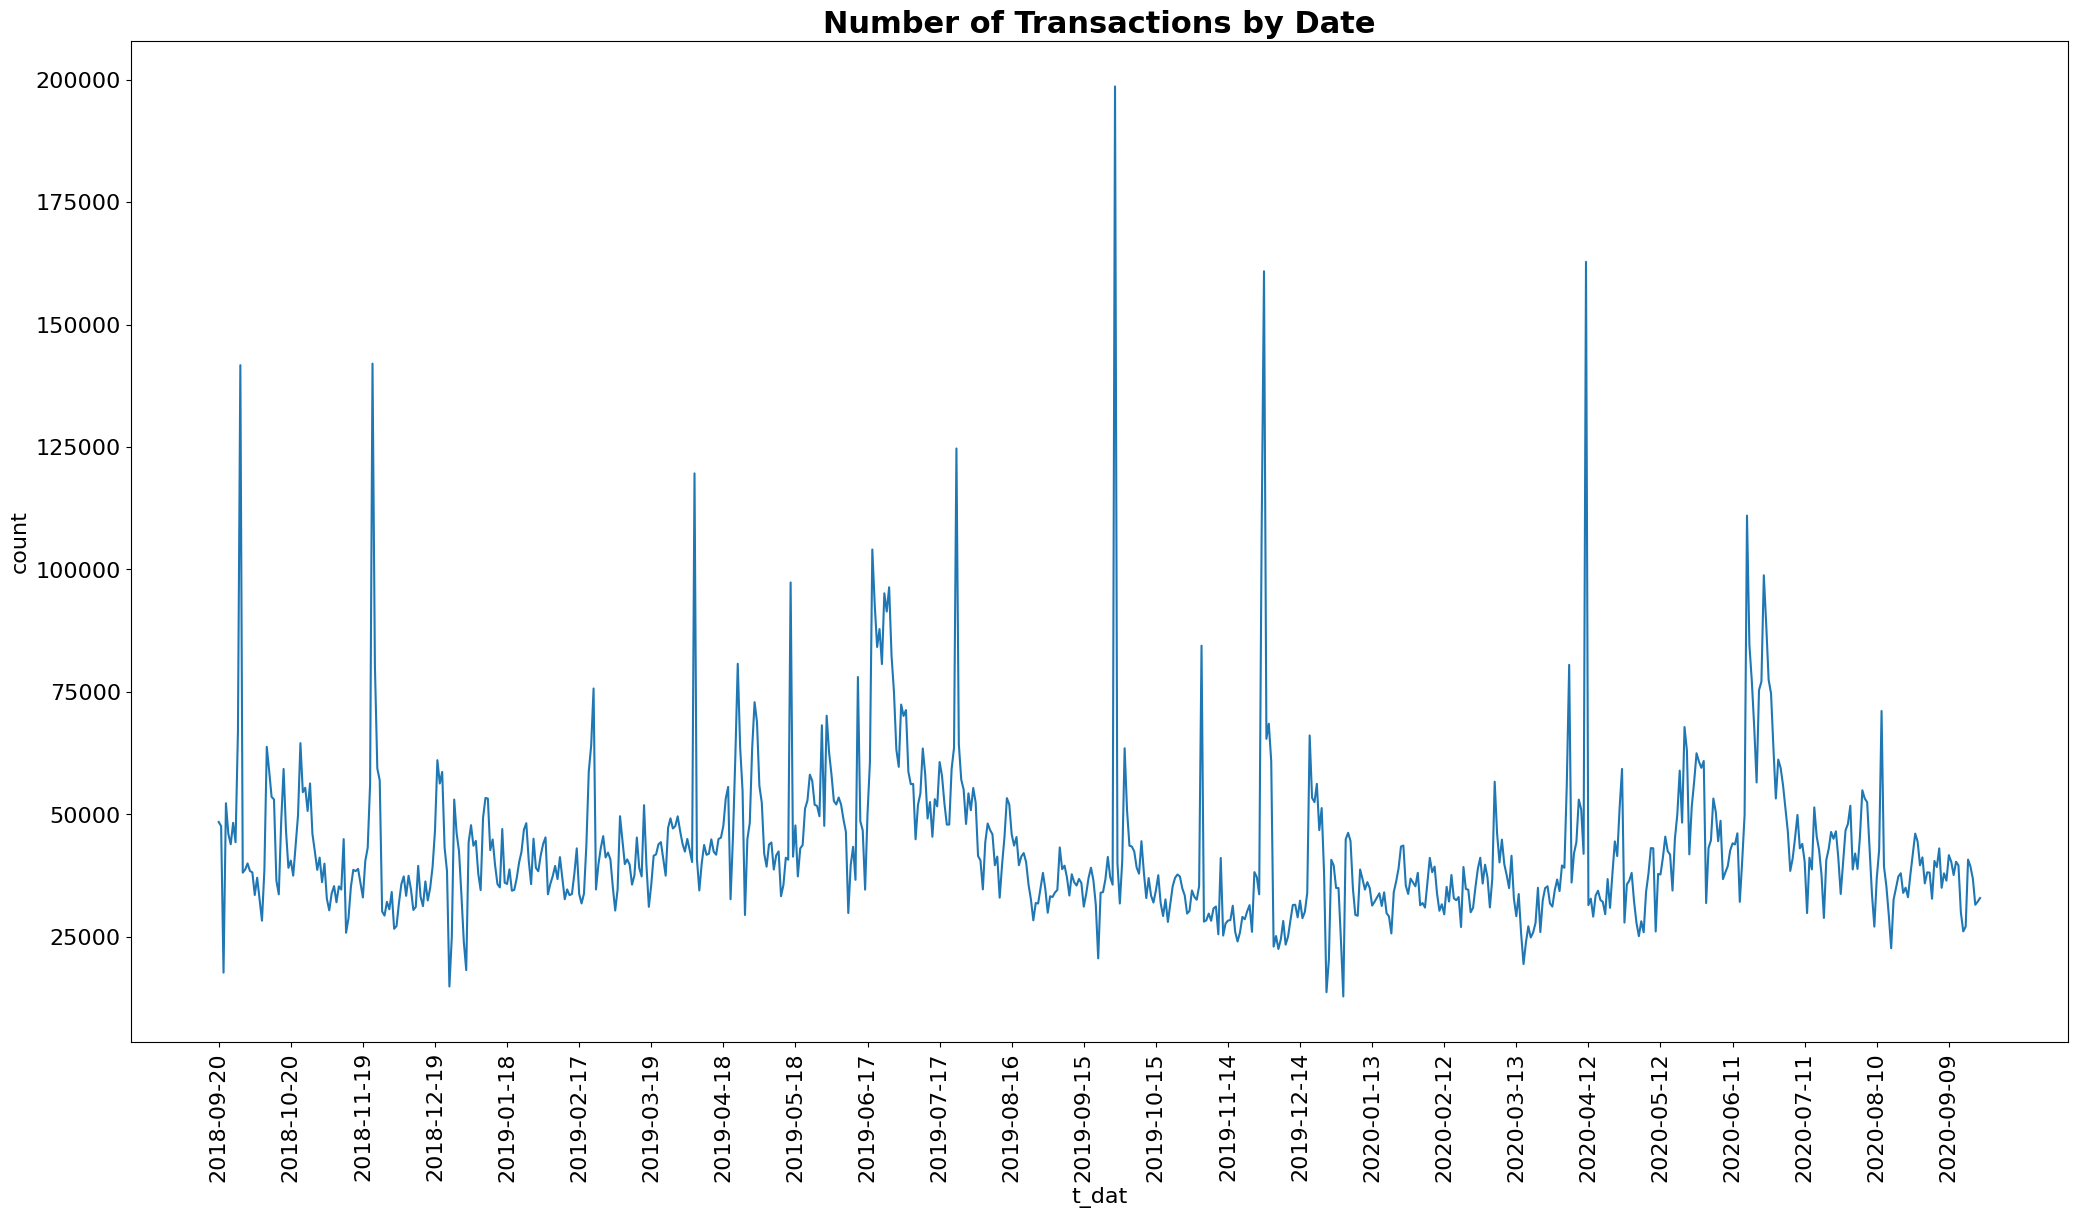

In [15]:
tran_count = transactions_parquet.groupby('t_dat')['customer_id'].count().reset_index().rename(columns = {'customer_id' : 'count'})

fig, ax = plt.subplots(figsize=(25, 13))
plt.title('Number of Transactions by Date', size=22, weight="bold")

sns.lineplot(x='t_dat', y='count', data=tran_count)
plt.xticks(np.arange(0, len(tran_count), 30), rotation=90)
plt.show()

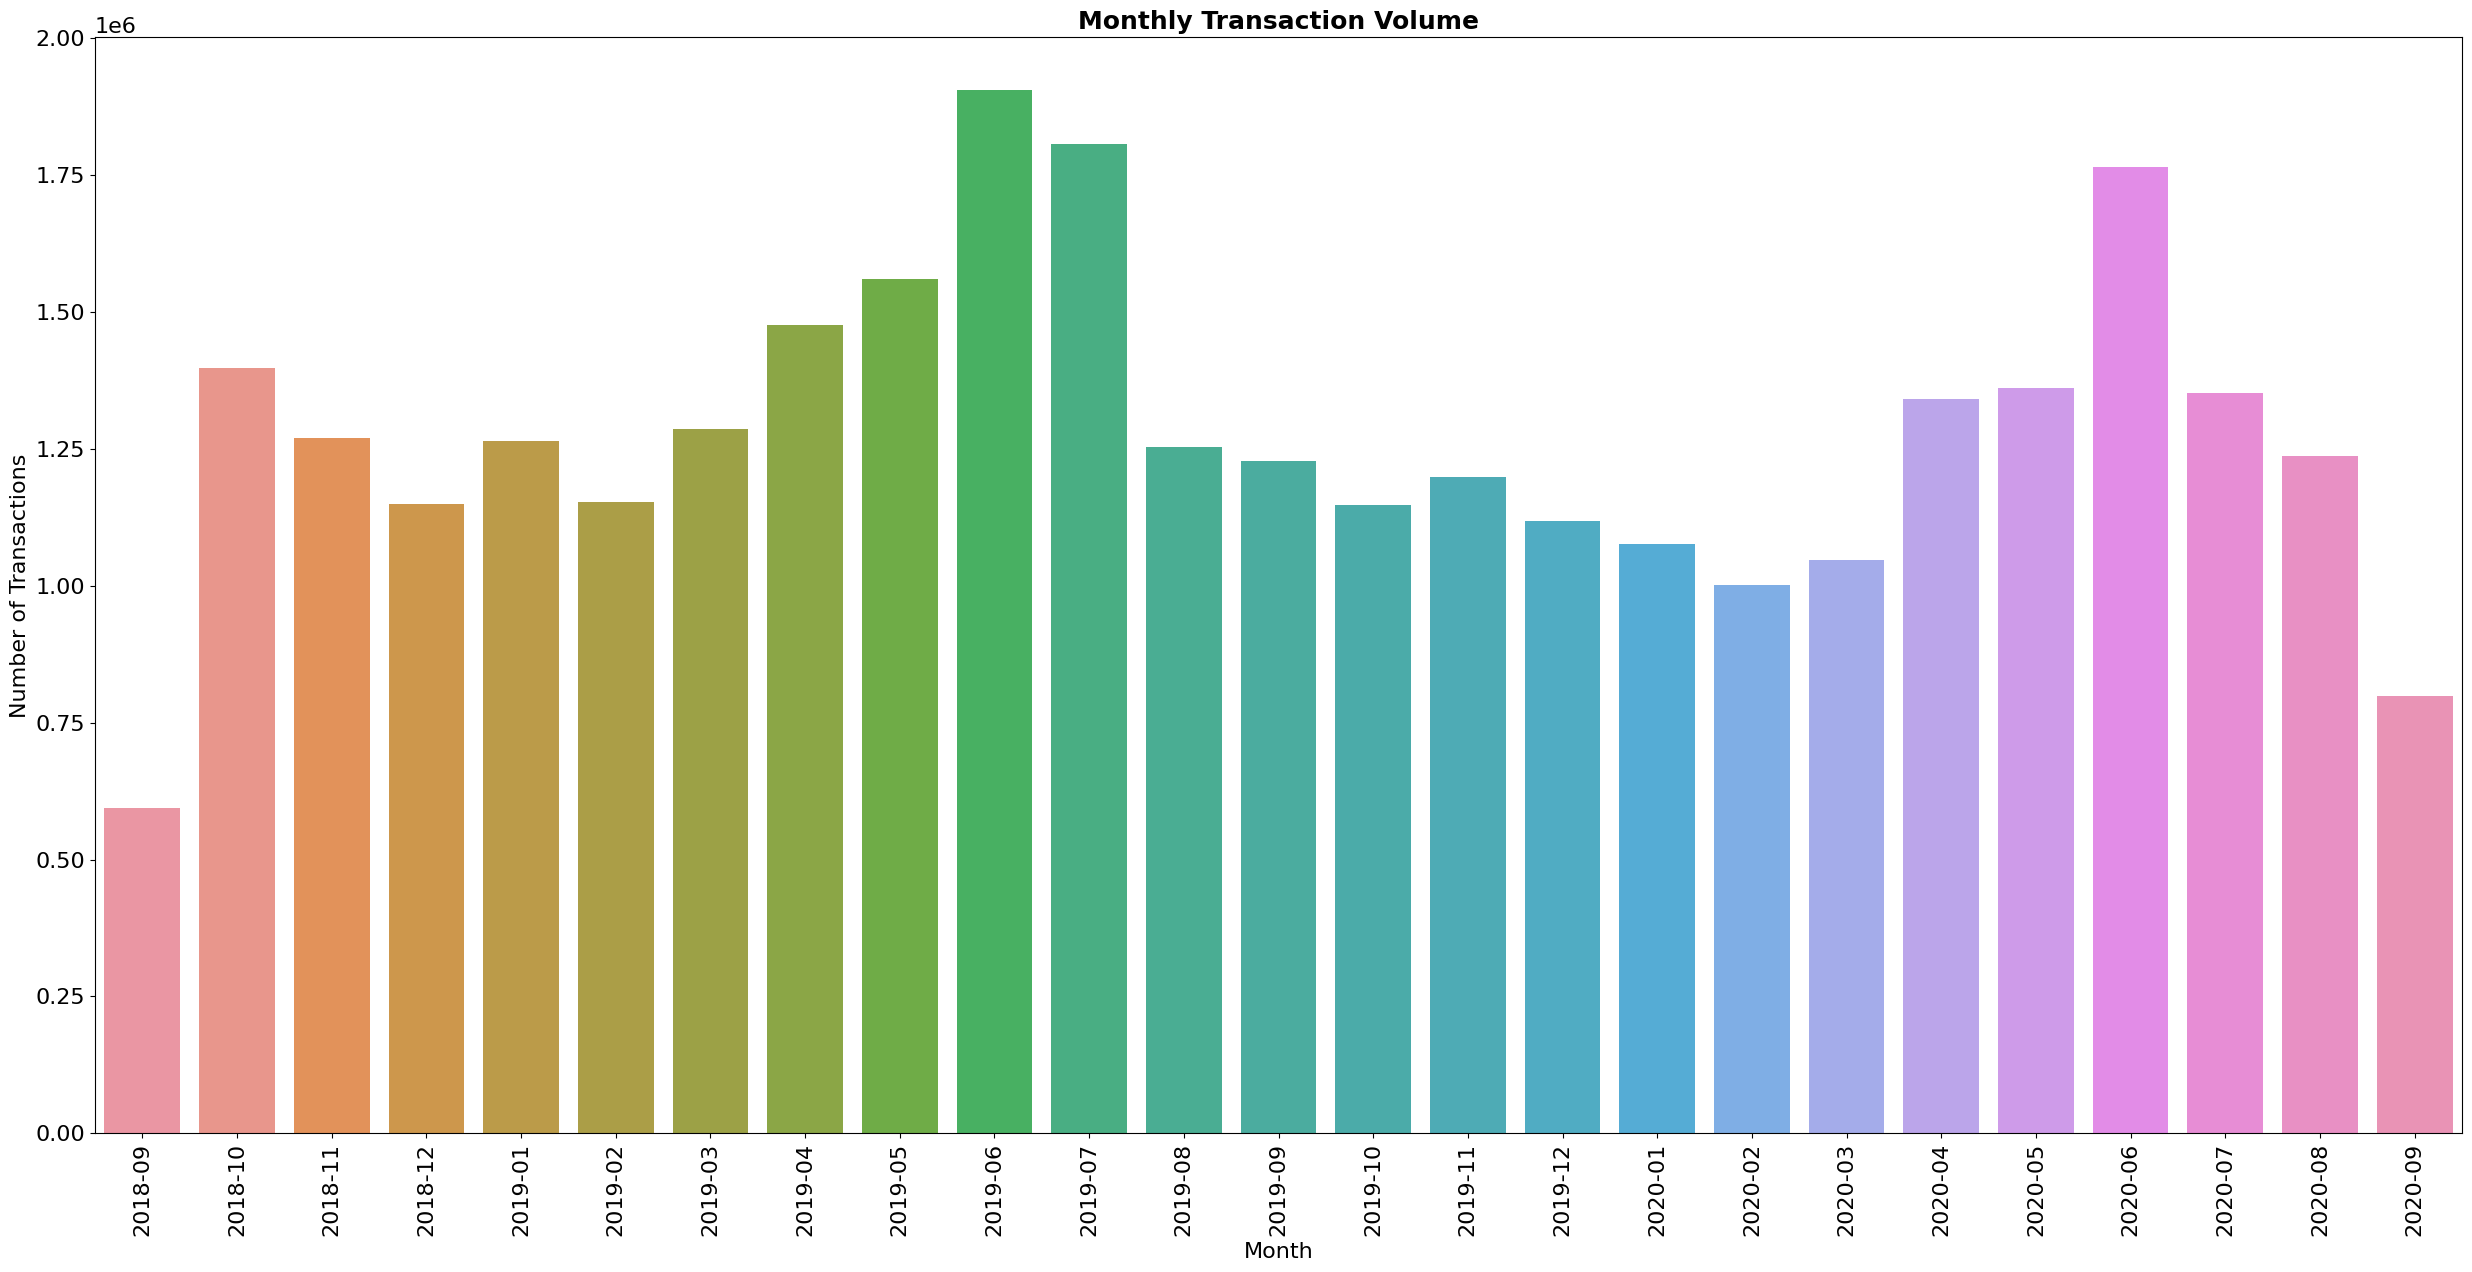

In [16]:
tran_count['t_dat'] = pd.to_datetime(tran_count['t_dat'])

tran_count['year_month'] = tran_count['t_dat'].dt.to_period('M')
monthly_vol = tran_count.groupby('year_month')['count'].sum().reset_index()
# monthly_vol['year_month'] = monthly_vol['year_month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(25, 13))
sns.barplot(x='year_month', y='count', data=monthly_vol, ax=ax)
plt.title('Monthly Transaction Volume', fontsize=18, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

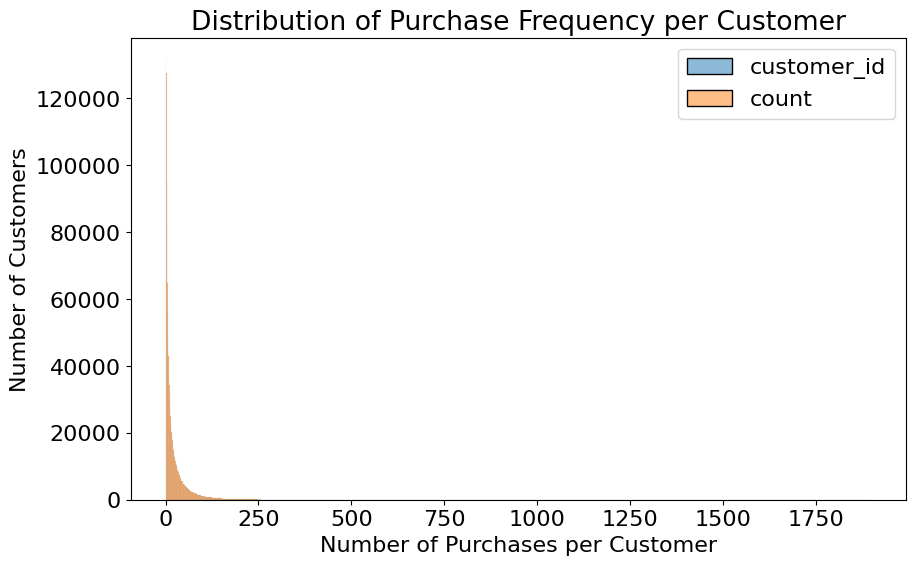

In [17]:
purchase_counts = transactions_parquet['customer_id'].value_counts().reset_index()

plt.figure(figsize=(10,6))
sns.histplot(purchase_counts, bins=range(1, purchase_counts['count'].max()+2), kde=False)
plt.xlabel('Number of Purchases per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Purchase Frequency per Customer')
plt.show()

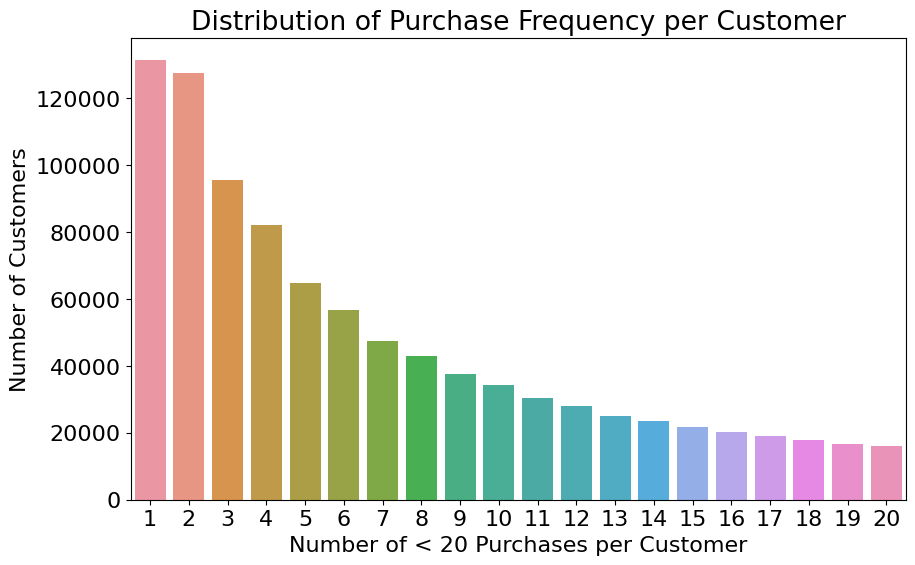

In [18]:
tmp = purchase_counts[purchase_counts['count']<=20].groupby('count')['customer_id'].count().reset_index().rename(columns={'count':'num_purchases', 'customer_id':'num_customers'})
plt.figure(figsize=(10,6))
sns.barplot(tmp, x='num_purchases', y='num_customers')
plt.xlabel('Number of < 20 Purchases per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Purchase Frequency per Customer')
plt.show()

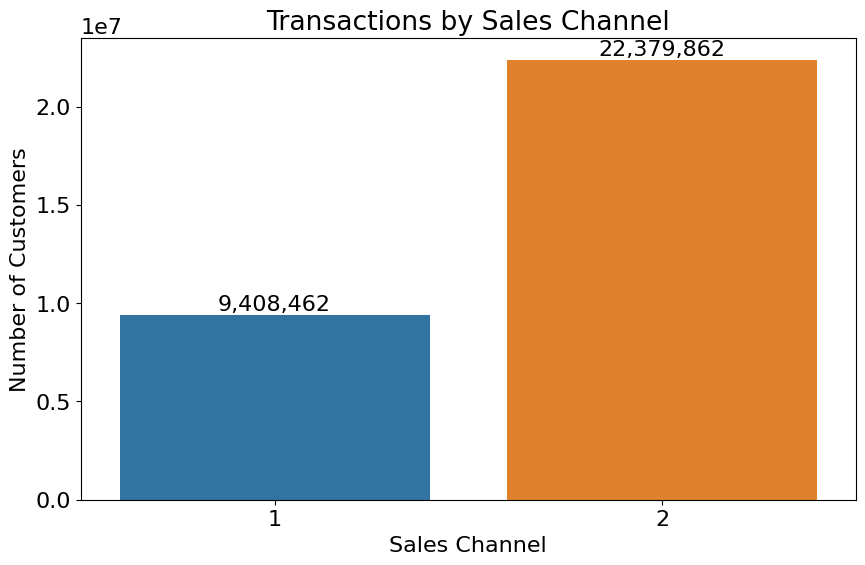

In [19]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x = 'sales_channel_id', data=transactions_parquet)
plt.xlabel('Sales Channel')
plt.ylabel('Number of Customers')
plt.title('Transactions by Sales Channel')

for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v):,}' for v in container.datavalues])
plt.show()

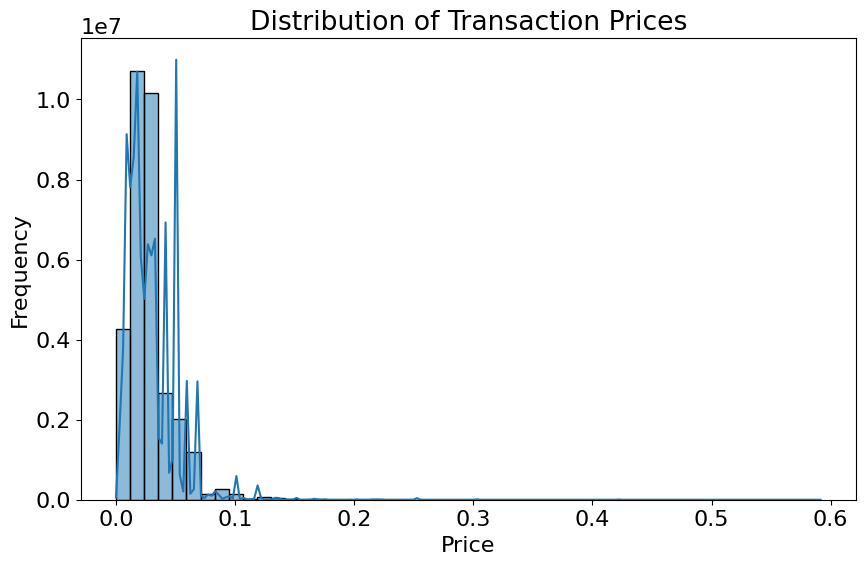

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=transactions_parquet, x='price', bins=50, kde=True)
plt.title('Distribution of Transaction Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

# Customers EDA

In [21]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,-7200416642310594310,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,-6846340800584936,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,-94071612138601410,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,-283965518499174310,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [22]:
customers.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [23]:
print(customers['FN'].value_counts(dropna=False))
print(customers['Active'].value_counts(dropna=False))
print(customers['club_member_status'].value_counts(dropna=False))
print(customers['fashion_news_frequency'].value_counts(dropna=False))

FN
NaN    895050
1.0    476930
Name: count, dtype: int64
Active
NaN    907576
1.0    464404
Name: count, dtype: int64
club_member_status
ACTIVE        1272491
PRE-CREATE      92960
NaN              6062
LEFT CLUB         467
Name: count, dtype: int64
fashion_news_frequency
NONE         877711
Regularly    477416
NaN           16011
Monthly         842
Name: count, dtype: int64


In [24]:
# Fill FN and Active - the only available value is "1"
customers["FN"].fillna(0, inplace=True)
customers["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customers["club_member_status"].fillna("UNKNOWN", inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None":"NONE"})
customers["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customers["age"].fillna(customers["age"].median(), inplace=True)

print(customers.isna().sum())

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64


In [25]:
def plot_values( df, col):

    print(clr.S+ f"Total Number of unique {col} values:"+clr.E, df[col].nunique())

    # Data
    val_cnt = df[col].value_counts().reset_index().head(15)
    clrs = ['#954E93' for x in val_cnt[col]]
    # clrs = ["#CB2170" if x==max(val_cnt[col]) else '#954E93' for x in val_cnt[col]]
    
    
    # Plot
    fig, ax = plt.subplots(figsize=(25, 13))
    plt.title(f'- Most Frequent {col} values -', size=22, weight="bold")
    
    sns.barplot(data=val_cnt, x="count", y=col, ax=ax,
                palette=clrs)

    show_values_on_bars(ax, h_v="h")
    
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.show()

In [35]:
customers.dtypes

customer_id                 int64
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [36]:
cust2 = customers.drop(['customer_id', 'postal_code', 'age'], axis=1)
cust2.value_counts()

FN   Active  club_member_status  fashion_news_frequency
0.0  0.0     ACTIVE              NONE                      787707
1.0  1.0     ACTIVE              Regularly                 457229
0.0  0.0     PRE-CREATE          NONE                       85057
1.0  0.0     ACTIVE              Regularly                  12055
0.0  0.0     ACTIVE              UNKNOWN                    11925
1.0  1.0     PRE-CREATE          Regularly                   5567
0.0  0.0     UNKNOWN             NONE                        3699
             PRE-CREATE          UNKNOWN                     2049
             UNKNOWN             UNKNOWN                     2035
             ACTIVE              Regularly                   2020
1.0  1.0     ACTIVE              Monthly                      735
                                 NONE                         487
0.0  0.0     LEFT CLUB           NONE                         459
1.0  1.0     UNKNOWN             Regularly                    307
     0.0     ACTIVE 

# Combined DataFrame

In [27]:
articles['article_id'] = articles['article_id'].astype('int64')

In [28]:
combined_df1 = transactions_parquet.merge(articles, on='article_id', how='left')
display_html(combined_df1.head(3))
del articles
del transactions_parquet

,t_dat,article_id,price,sales_channel_id,customer_id,article_id2,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,663713001,0.050831,2,-6846340800584936,663713001,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1338,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,541518023,0.030492,2,-6846340800584936,541518023,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,1010016,Solid,51,Light Pink,1,Dusty Light,4,Pink,1334,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,505221004,0.015237,2,-8334631767138808638,505221004,505221,Inca Jumper,252,Sweater,Garment Upper body,1010010,Melange,52,Pink,2,Medium Dusty,4,Pink,5963,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...


In [31]:
combined_df1 = combined_df1[['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_code', 'prod_name', 'product_type_name',
       'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name',
       'perceived_colour_master_name',
       'department_name', 'index_name',
       'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc']]

In [32]:
combined_df = combined_df1.merge(customers, on='customer_id', how='left')
display_html(combined_df.head(3))
del combined_df1

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,-6846340800584936,663713001,0.050831,2,663713,Atlanta Push Body Harlow,Underwear body,Underwear,Solid,Black,Dark,Black,Expressive Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
1,2018-09-20,-6846340800584936,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,Bra,Underwear,Solid,Light Pink,Dusty Light,Pink,Casual Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa...",0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
2,2018-09-20,-8334631767138808638,505221004,0.015237,2,505221,Inca Jumper,Sweater,Garment Upper body,Melange,Pink,Medium Dusty,Pink,Tops Knitwear DS,Divided,Divided,Divided Selected,Knitwear,Jumper in rib-knit cotton with hard-worn detai...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...


In [33]:
print(clr.S+"Total Number of Transacting Customers"+clr.E, \
          f"{combined_df['customer_id'].nunique():,}")
print(clr.S+"Total Number of Unique Articles purchased"+clr.E, \
          f"{combined_df['article_id'].nunique():,}")
print(clr.S+"Min Price of items purchased"+clr.E, \
          combined_df['price'].min())
print(clr.S+"Max Price of items purchased"+clr.E, \
          combined_df['price'].max())
print(clr.S+"Total Number of unique Addresses:"+clr.E, \
          f"{combined_df['postal_code'].nunique():,}")

Total Number of Transacting Customers 1,362,281
Total Number of Unique Articles purchased 104,547
Min Price of items purchased 1.694915254237288e-05
Max Price of items purchased 0.5915254237288136
Total Number of unique Addresses: 352,336


In [34]:
print(clr.S+"Missing values within customers dataset:"+clr.E)
print(combined_df.isna().sum())

Missing values within customers dataset:
t_dat                           0
customer_id                     0
article_id                      0
price                           0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_name               0
product_group_name              0
graphical_appearance_name       0
colour_group_name               0
perceived_colour_value_name     0
perceived_colour_master_name    0
department_name                 0
index_name                      0
index_group_name                0
section_name                    0
garment_group_name              0
detail_desc                     0
FN                              0
Active                          0
club_member_status              0
fashion_news_frequency          0
age                             0
postal_code                     0
dtype: int64


In [37]:
print(combined_df['FN'].value_counts(dropna=False))
print(combined_df['Active'].value_counts(dropna=False))
print(combined_df['club_member_status'].value_counts(dropna=False))
print(combined_df['fashion_news_frequency'].value_counts(dropna=False))

FN
0.0    18209837
1.0    13578487
Name: count, dtype: int64
Active
0.0    18412468
1.0    13375856
Name: count, dtype: int64
club_member_status
ACTIVE        31057401
PRE-CREATE      660219
UNKNOWN          62165
LEFT CLUB         8539
Name: count, dtype: int64
fashion_news_frequency
NONE         18029637
Regularly    13606657
UNKNOWN        141713
Monthly         10317
Name: count, dtype: int64


In [38]:
# Fill FN and Active - the only available value is "1"
combined_df["FN"].fillna(0, inplace=True)
combined_df["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
combined_df["club_member_status"].fillna("UNKNOWN", inplace=True)

combined_df["fashion_news_frequency"] = combined_df["fashion_news_frequency"].replace({"None":"NONE"})
combined_df["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
combined_df["age"].fillna(customers["age"].median(), inplace=True)

combined_df['detail_desc'].fillna(" ", inplace=True)

print(combined_df.isna().sum())

t_dat                           0
customer_id                     0
article_id                      0
price                           0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_name               0
product_group_name              0
graphical_appearance_name       0
colour_group_name               0
perceived_colour_value_name     0
perceived_colour_master_name    0
department_name                 0
index_name                      0
index_group_name                0
section_name                    0
garment_group_name              0
detail_desc                     0
FN                              0
Active                          0
club_member_status              0
fashion_news_frequency          0
age                             0
postal_code                     0
dtype: int64


#### Seasonality

In [39]:
combined_df['Month-Year'] = combined_df['t_dat'].str.slice(0, 7)

prod_cnt_df = combined_df.groupby(['Month-Year', 'product_type_name'])\
                ['product_type_name'].count().rename('Count').reset_index()
most_purchased = prod_cnt_df.groupby('Month-Year').apply(lambda x: x.nlargest(10, 'Count'))

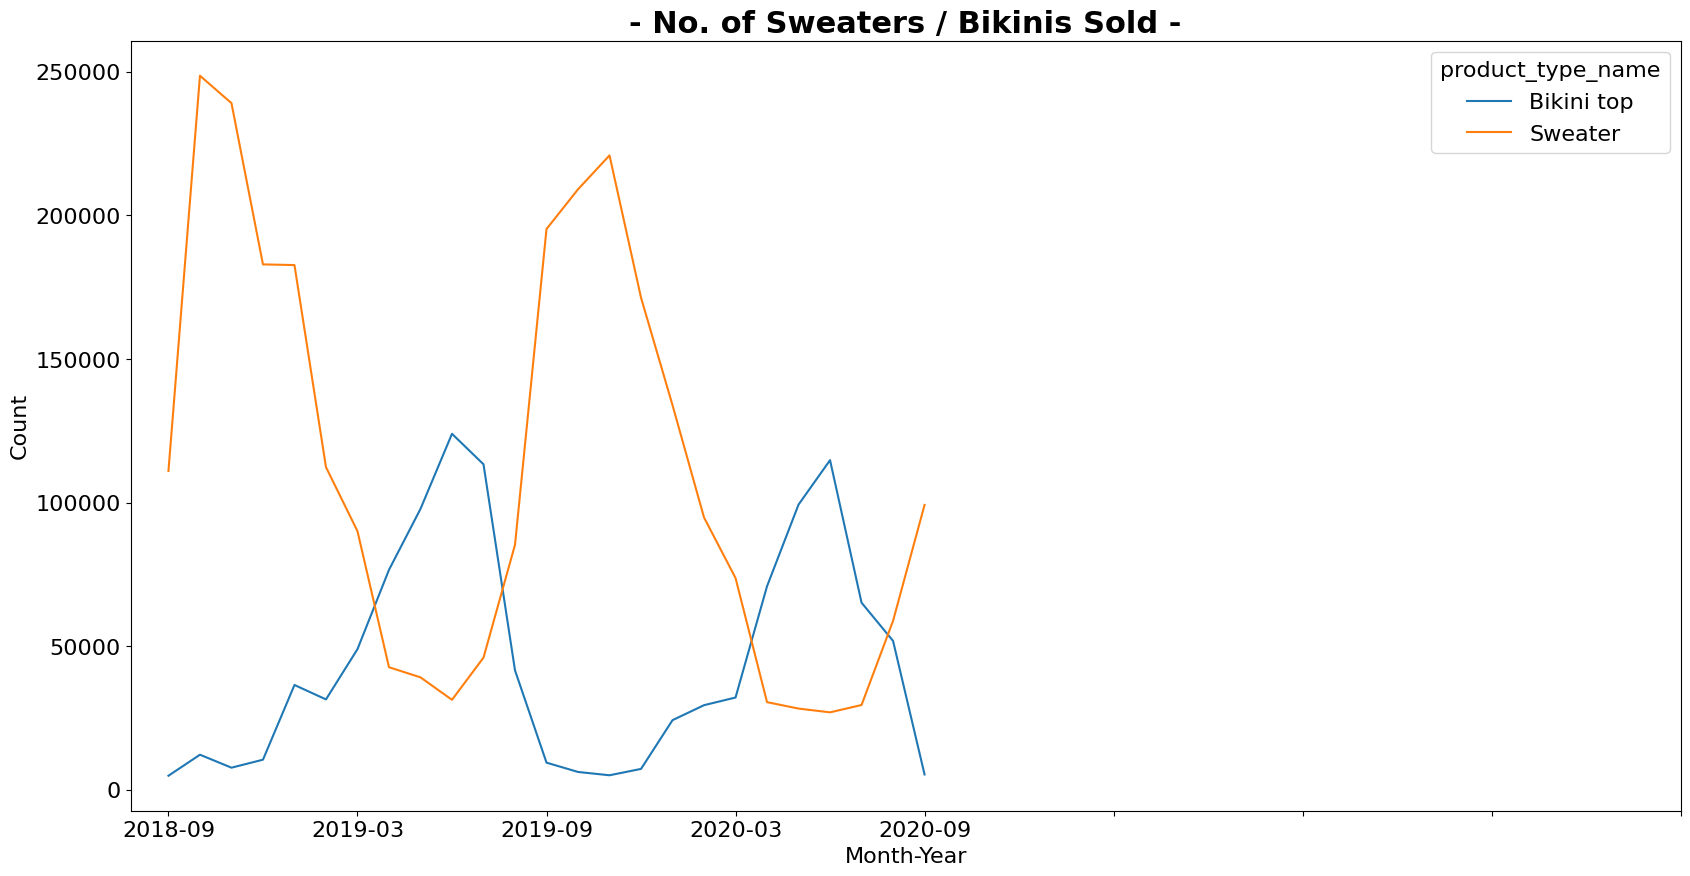

In [40]:
sweater_cnt_df = prod_cnt_df[(prod_cnt_df['product_type_name'] == 'Sweater') | (prod_cnt_df['product_type_name'] == 'Bikini top')]

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('- No. of Sweaters / Bikinis Sold -', size=22, weight="bold")


sns.lineplot(x='Month-Year', y='Count', data=sweater_cnt_df, ax=ax, hue = 'product_type_name', markers='*')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

ticks = range(0, len(sweater_cnt_df), 6)
plt.xticks(ticks)
plt.show()

##### Purchase Preferences According to Age

In [41]:
combined_df['age'].describe()

count    3.178832e+07
mean     3.602045e+01
std      1.295413e+01
min      1.600000e+01
25%      2.500000e+01
50%      3.100000e+01
75%      4.700000e+01
max      9.900000e+01
Name: age, dtype: float64

In [42]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

combined_df["age_interval"] = combined_df["age"].apply(lambda x: create_age_interval(x))

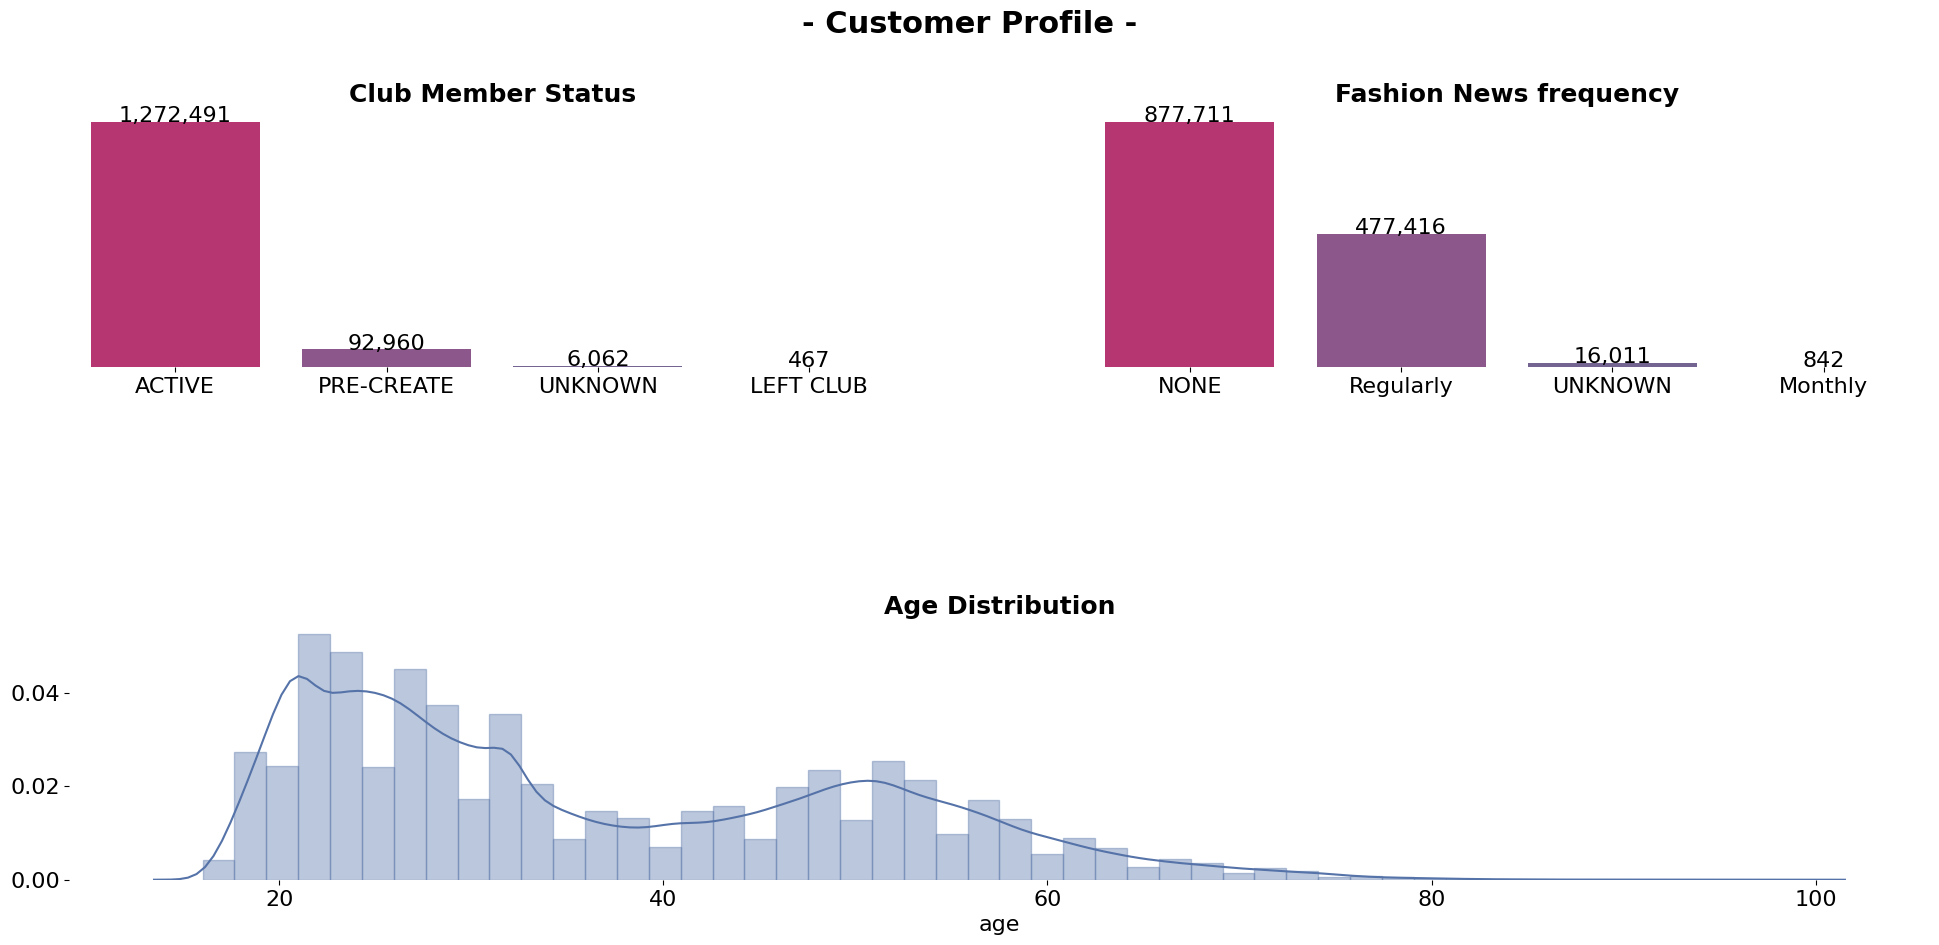

In [43]:
plt.figure(figsize=(24, 10))
plt.suptitle('- Customer Profile -', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.countplot(data=customers, x="club_member_status", ax=ax1,
              order=customers['club_member_status'].value_counts().index,
              palette=my_colors[2:])
show_values_on_bars(axs=ax1, h_v="v", space=0.4)
ax1.set_title("Club Member Status", size=18, weight="bold")
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

sns.countplot(data=customers, x="fashion_news_frequency", ax=ax2,
              order=customers['fashion_news_frequency'].value_counts().index,
              palette=my_colors[2:])
show_values_on_bars(axs=ax2, h_v="v", space=0.4)
ax2.set_title("Fashion News frequency", size=18, weight="bold")
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

sns.distplot(customers["age"], color=my_colors[-3], ax=ax3,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax3.set_title("Age Distribution", size=18, weight="bold")
ax3.set_ylabel("")

for ax in [ax1, ax2]:
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    # ax.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')
    
# insert_image(path='../input/hm-fashion-recommender-dataset/pics/vans.jpg', zoom=0.5, xybox=(60, 0.00), ax=ax3)

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.99);

In [44]:
def create_age_interval2(x):
    if x <= 25:
        return '16-25'
    elif x <= 35:
        return '26-35'
    elif x <= 45:
        return '36-45'
    elif x <= 55:
        return '46-55'
    elif x <= 65:
        return '56-65'
    else:
        return '66-99'

combined_df["age_interval"] = combined_df["age"].apply(lambda x: create_age_interval2(x))

In [45]:
age_prod_df = combined_df.groupby(['age_interval', 'sales_channel_id'])['sales_channel_id'].count().rename('Count').reset_index()
# most_purchased = age_prod_df.groupby('age_interval').apply(lambda x: x.nlargest(6, 'Count'))
age_prod_df['channel-wise %'] = age_prod_df['Count'] / age_prod_df.groupby('age_interval')['Count'].transform('sum') * 100

age_prod_df.head(1000)

,age_interval,sales_channel_id,Count,channel-wise %
0,16-25,1,2601400,32.093160
1,16-25,2,5504377,67.906840
2,26-35,1,2649574,24.876812
3,26-35,2,8001204,75.123188
4,36-45,1,1175341,28.935972
5,36-45,2,2886527,71.064028
6,46-55,1,2025828,33.221928
7,46-55,2,4072036,66.778072
8,56-65,1,779159,32.593240
9,56-65,2,1611395,67.406760


In [48]:
age_prod_df = combined_df.groupby(['age_interval', 'prod_name'])['perceived_colour_value_name'].count().rename('Count').reset_index()
most_purchased = age_prod_df.groupby('age_interval').apply(lambda x: x.nlargest(10, 'Count'))

most_purchased.head(1000)

age_interval                    prod_name  Count
age_interval                                                        
16-25        17495         16-25     Jade HW Skinny Denim TRS  64697
             35932         16-25                   Tilda tank  37271
             35979         16-25       Timeless Midrise Brief  36728
             21676         16-25               Luna skinny RW  32010
             33159         16-25  Simple as That Triangle Top  29472
             35942         16-25                    Tilly (1)  25847
             6956          16-25                     Cat Tee.  25026
             33160         16-25  Simple as that Cheeky Tanga  23747
             29112         16-25                  RICHIE HOOD  21637
             35773         16-25                  Therese tee  20995
26-35        57945         26-35     Jade HW Skinny Denim TRS  48543
             62579         26-35               Luna skinny RW  47632
             78562         26-35       Timeless Midrise Brief  41774
             78520         26-35                    Tilly (1)  36841
             46453         26-35                     Cat Tee.  31115
             75019         26-35       Shake it in Balconette  28267
             66765         26-35                 Nora T-shirt  24731
             75490         26-35  Simple as That Triangle Top  21898
             49880         26-35                    Despacito  21856
             75491         26-35  Simple as that Cheeky Tanga  21383
36-45        104748        36-45               Luna skinny RW  19098
             100243        36-45     Jade HW Skinny Denim TRS  15088
             120285        36-45       Timeless Midrise Brief  14594
             120247        36-45                    Tilly (1)  13516
             116854        36-45       Shake it in Balconette  10667
             89067         36-45                     Cat Tee.   9790
             108820        36-45                 Nora T-shirt   8802
             112453        36-45          Push Up Jegging L.W   8636
             117463        36-45    Skinny Ankle R.W Brooklyn   8620
             114131        36-45            S.Skinny L.W Epic   8454
46-55        141234        46-55     Jade HW Skinny Denim TRS  30309
             145530        46-55               Luna skinny RW  29458
             160457        46-55       Timeless Midrise Brief  22957
             160419        46-55                    Tilly (1)  17736
             152519        46-55          Pluto RW slacks (1)  17600
             157705        46-55    Skinny Ankle R.W Brooklyn  15758
             152874        46-55                 Primo slacks  15442
             157572        46-55  Simple as That Triangle Top  14283
             157114        46-55       Shake it in Balconette  13949
             133645        46-55                    Despacito  13812
56-65        183589        56-65               Luna skinny RW  12611
             197073        56-65                    Tilly (1)   9148
             189950        56-65          Pluto RW slacks (1)   8957
             190282        56-65                 Primo slacks   8733
             179642        56-65     Jade HW Skinny Denim TRS   8437
             194606        56-65    Skinny Ankle R.W Brooklyn   8097
             172798        56-65                    Despacito   7362
             187113        56-65                 Nora T-shirt   6724
             169356        56-65                  Calista (1)   6500
             180845        56-65              Kanta slacks RW   6272
66-99        222771        66-99    Skinny Ankle R.W Brooklyn   2923
             219676        66-99                 Primo slacks   2655
             224590        66-99                    Tilly (1)   2582
             214642        66-99               Luna skinny RW   2407
             204078        66-99                  Calista (1)   2221
             219420        66-99          Pluto RW slacks (1)   2031
             20659